<div class="alert alert-info">
My awesome notebook for muon $p_{\mathrm{T}}$ regression.
</div>

In [1]:
from nn_globals import *

from nn_encode import (nlayers, nvariables, create_encoder)

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, reduce_lr)

from nn_training import train_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


### Parameters

In [2]:
# Train a new model or use an existing model
do_training = False

# Specify inputs for the training
# - default: muon gun with a uniform distribution in 1/pT, eta, phi (pT>2, 1.2<|eta|<2.5)
# - run2   : default minus Phase-2 trigger primitives
# - omtf   : muon gun in the overlap region (pT>3, 0.8<|eta|<1.4)
# - displ  : displaced muons with 0<|d0|<120 cm
# - mixing : tracks from MinBias PU200 events
# - collus : tracks from SingleMu+PU200 events
run2_input = False

omtf_input = False

displ_input = True

mixing_input = True

collus_input = True

# Training parameters
model_name = 'model16'

nodes = [30,25,20]

learning_rate = 0.01

gradient_clip_norm = 1.

epochs = 150

batch_size = 2048

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450

In [3]:
#FIXME
infile_pileup = '../test7/histos_tbd_alt.27.npz'

In [4]:
#FIXME
from nn_models import (Sequential, Dense, BatchNormalization, Activation,
                       regularizers, optimizers)

from tensorflow.python.ops.distributions import special_math

def emlf_loss(y_true, y_pred, reg_pt_scale=100., reg_dxy_scale=0.4, return_everything=False):
  t = y_pred
  u = y_true

  _ones = K.ones_like(t[..., 0:1], dtype=K.floatx())

  def _cast(x):
    x = K.cast(x, dtype=K.floatx())
    return x

  def _weighted_cast(x):
    x = K.cast(x, dtype=K.floatx())
    x /= (K.mean(x) + K.epsilon())
    return x

  def _log_prob_em(x, loc, scale, low, high, delta, normalize=False):
    standardize = lambda x: -(x - loc) / scale  # NOTE: uses (loc - x)
    # In the range (a0, b0), c0 -> 0 to -1 from a0 to b0, before the final +1. So, c0 -> 1 to 0
    # Outside the range, c0 = +1
    #a0, b0 = high - delta, high
    #c0 = _cast(x >= a0) * (- (x - a0) / (b0 - a0)) + 1
    c0 = 1
    # In the range (a1, b1), c1 -> -1 to 0 from a1 to b1, before the final +1. So, c1 -> 0 to 1
    # Outside the range, c1 = +1
    #a1, b1 = low, low + delta
    #c1 = _cast(x < b1) * ((x - a1) / (b1 - a1) - 1) + 1
    c1 = 1
    log_prob = -(tf.nn.softplus(-standardize(x)) * c1 +  # positive term
                 tf.nn.softplus(standardize(x)) * c0 +   # negative term
                 K.log(scale))
    if normalize:
      log_prob *= 2. / (c0 + c1)
    return log_prob

  def _log_prob_normal(x, loc, scale):
    # Log probability for Normal, see:
    #   https://en.wikipedia.org/wiki/Normal_distribution
    #   https://github.com/tensorflow/probability/blob/v0.6.0/tensorflow_probability/python/distributions/normal.py
    standardize = lambda x: (x - loc) / scale
    log_prob = -(0.5 * K.square(standardize(x)) +
                 0.5 * np.log(2. * np.pi) +
                 K.log(scale))
    return log_prob

  def _log_prob_truncated_normal(x, loc, scale, low, high):
    # Log probability for Truncated Normal, see:
    #   https://en.wikipedia.org/wiki/Truncated_normal_distribution
    #   https://github.com/tensorflow/probability/blob/v0.6.0/tensorflow_probability/python/distributions/truncated_normal.py
    standardize = lambda x: (x - loc) / scale
    tiny = np.float32(1e-15)
    eps = np.finfo(np.float32).eps
    log_prob_normalizer = (special_math.ndtr(standardize(high)) -
                           special_math.ndtr(standardize(low)))
    log_prob_normalizer = tf.clip_by_value(log_prob_normalizer, tiny, 1. - eps)
    log_prob = -(0.5 * K.square(standardize(x)) +
                 0.5 * np.log(2. * np.pi) +
                 K.log(scale * log_prob_normalizer))
    return log_prob

  def _log_prob_huber_normal(x, loc, scale):
    # Normal, but replacing the famous square function by pseudo-huber loss function
    #   https://en.wikipedia.org/wiki/Huber_loss#Pseudo-Huber_loss_function
    standardize = lambda x: (x - loc) / scale
    log_prob = -(1.0 * (K.sqrt(K.square(standardize(x)) + 1) - 1) +
                 0.5 * np.log(2. * np.pi) +
                 K.log(scale))
    return log_prob

  def _log_prob_bce(labels, logits):
    log_prob_bce = -tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    return log_prob_bce

  def _l1_loss(y_true, y_pred):
    loss = K.abs(y_true - y_pred)
    loss *= -1
    return loss

  def _l2_loss(y_true, y_pred):
    loss = 0.5 * K.square(y_true - y_pred)
    loss *= -1
    return loss

  def _huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5 * K.square(x)
    absolute_loss = delta * (x - 0.5 * delta)
    loss = tf.where(x < delta, squared_loss, absolute_loss)
    loss *= -1
    return loss

  # Classes
  masks_prompt = K.equal(u[..., 3:4], MASKS.prompt)
  masks_displ = K.equal(u[..., 3:4], MASKS.displ)
  masks_pileup = K.equal(u[..., 3:4], MASKS.pileup)
  masks_pileupx = K.equal(u[..., 3:4], MASKS.pileupx)

  # Par 0: vertex-constrained pT
  low0 = 0.0 * reg_pt_scale     # infinite
  high0 = 0.5 * reg_pt_scale    # 2 GeV
  delta0 = 0.25 * reg_pt_scale  # 4 GeV
  #delta0 = 0.4 * reg_pt_scale  # 2.5 GeV

  y_true0 = K.abs(u[..., 0:1])
  y_true0 = tf.clip_by_value(y_true0, low0, high0)
  y_true0 = tf.where(masks_pileupx, high0 * _ones, y_true0)  # overwrite 'pileupx' with 2 GeV
  #q_true0 = tf.where(u[..., 0:1] < 0, 0. * _ones, 1. * _ones)
  q_true0 = u[..., 0:1]
  q_true0 = tf.clip_by_value(q_true0, -high0, high0)

  c = np.log(np.expm1(high0))  # shifted to 2 GeV
  #y_pred0 = t[..., 0:1]
  y_pred0 = t[..., 0:1] + c
  q_pred0 = t[..., 1:2]
  scale0 = 1e-5 + tf.nn.softplus(0.01 * t[..., 2:3])

  # Par 1: vertex-unconstrained pT
  low1 = 0.0 * reg_pt_scale     # infinite
  high1 = 0.5 * reg_pt_scale    # 2 GeV
  delta1 = 0.25 * reg_pt_scale  # 4 GeV

  y_true1 = K.abs(u[..., 1:2])
  y_true1 = tf.clip_by_value(y_true1, low1, high1)
  y_true1 = tf.where(masks_pileupx, high1 * _ones, y_true1)  # overwrite 'pileupx' with 2 GeV
  #q_true1 = tf.where(u[..., 1:2] < 0, 0. * _ones, 1. * _ones)
  q_true1 = u[..., 1:2]
  q_true1 = tf.clip_by_value(q_true1, -high1, high1)

  c = np.log(np.expm1(high1))  # shifted to 2 GeV
  #y_pred1 = t[..., 3:4]
  y_pred1 = t[..., 3:4] + c
  q_pred1 = t[..., 4:5]
  scale1 = 1e-5 + tf.nn.softplus(0.01 * t[..., 5:6])

  # Par 2: transverse impact parameter, d0
  low2 = 0. * reg_dxy_scale      # 0 cm
  high2 = 100. * reg_dxy_scale   # 100 cm
  delta2 = 75. * reg_dxy_scale   # 75 cm

  y_true2 = K.abs(u[..., 2:3])
  y_true2 = tf.clip_by_value(y_true2, low2, high2)
  y_true2 = tf.where(masks_pileupx, low2 * _ones, y_true2)  # overwrite 'pileupx' with 0 cm
  #q_true2 = tf.where(u[..., 2:3] < 0, 0. * _ones, 1. * _ones)
  q_true2 = u[..., 2:3]
  q_true2 = tf.clip_by_value(q_true2, -high2, high2)

  y_pred2 = t[..., 6:7]
  q_pred2 = t[..., 7:8]
  scale2 = 1e-5 + tf.nn.softplus(0.01 * t[..., 8:9])

  # Log probs
  #log_prob0 = _l2_loss(y_true0, y_pred0)
  #log_prob0 = _huber_loss(y_true0, y_pred0)
  #log_prob0 = _log_prob_normal(y_true0, y_pred0, scale0)
  #log_prob0 = _log_prob_truncated_normal(y_true0, y_pred0, scale0, low0, high0)
  log_prob0 = _log_prob_huber_normal(y_true0, y_pred0, scale0)
  #log_prob0 = _log_prob_em(y_true0, y_pred0, scale0, low0, high0, delta0)
  log_prob_q0 = _log_prob_huber_normal(q_true0, q_pred0, scale0)
  log_prob_pu0 = log_prob0

  log_prob1 = _log_prob_huber_normal(y_true1, y_pred1, scale1)
  #log_prob1 = _log_prob_em(y_true1, y_pred1, scale1, low1, high1, delta1)
  log_prob_q1 = _log_prob_huber_normal(q_true1, q_pred1, scale1)
  log_prob_pu1 = log_prob1

  log_prob2 = _log_prob_huber_normal(y_true2, y_pred2, scale2)
  #log_prob2 = _log_prob_em(y_true2, y_pred2, scale2, low2, high2, delta2)
  log_prob_q2 = _log_prob_huber_normal(q_true2, q_pred2, scale2)
  log_prob_pu2 = log_prob2

  # Weights
  weight_lp0 = 1.0
  weight_lpq0 = 0.1
  weight_lppu0 = 0.2

  weight_lp1 = 0.5
  weight_lpq1 = 0.05
  weight_lppu1 = 0.1

  weight_lp2 = 0.5
  weight_lpq2 = 0.05
  weight_lppu2 = 0.1

  # Masks
  masks_lp0 = _weighted_cast(masks_prompt) * weight_lp0
  masks_lpq0 = _weighted_cast(masks_prompt) * weight_lpq0
  masks_lppu0 = _weighted_cast(masks_pileup | masks_pileupx) * weight_lppu0

  masks_lp1 = _weighted_cast(masks_displ) * weight_lp1
  masks_lpq1 = _weighted_cast(masks_displ) * weight_lpq1
  masks_lppu1 = _weighted_cast(masks_pileup | masks_pileupx) * weight_lppu1

  masks_lp2 = _weighted_cast(masks_displ) * weight_lp2
  masks_lpq2 = _weighted_cast(masks_displ) * weight_lpq2
  masks_lppu2 = _weighted_cast(masks_pileup | masks_pileupx) * weight_lppu2

  # Loss
  #loss = -(log_prob0 * masks_lp0)
  #loss = -(log_prob0 * masks_lp0 + log_prob_q0 * masks_lpq0)
  loss = -(log_prob0 * masks_lp0 + log_prob0 * masks_lppu0)
  loss = K.mean(loss, axis=-1)
  components = (y_true0, log_prob0, masks_lp0, log_prob_q0, masks_lpq0, log_prob_pu0, masks_lppu0,
                y_true1, log_prob1, masks_lp1, log_prob_q1, masks_lpq1, log_prob_pu1, masks_lppu1,
                y_true2, log_prob2, masks_lp2, log_prob_q2, masks_lpq2, log_prob_pu2, masks_lppu2)

  if return_everything:
    return loss, components
  else:
    return loss

def create_model_sequential_emlf(nodesIn=36, nodesOut=1, nodes1=30, nodes2=25, nodes3=20, loss=None):
  '''Create a Sequential model for a dense NN with 3 hidden layers.'''

  model = Sequential([
    # BN layer right after the input layer
    BatchNormalization(input_shape=(nodesIn,), epsilon=1e-4, momentum=0.9),
    # Hidden layer 1
    Dense(nodes1, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 2
    Dense(nodes2, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 3
    Dense(nodes3, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Output layer
    Dense(nodesOut, kernel_initializer='zeros', use_bias=True, activation=None),
  ])

  # Set loss and optimizer
  adam = optimizers.Adam(lr=learning_rate, clipnorm=gradient_clip_norm)
  model.compile(optimizer=adam, loss=loss)
  return model

In [5]:
# Freeze some function keywords
from functools import partial

create_encoder_1 = partial(create_encoder,
                           reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)

emlf_loss_1 = partial(emlf_loss,
                      reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
emlf_loss_1.__name__ = emlf_loss.__name__  # needed for Keras save_model()

create_model_1 = partial(create_model_sequential_emlf,
                         nodesIn=nvariables, nodesOut=9, loss=emlf_loss_1)

train_model_1 = partial(train_model,
                        model_name=model_name, callbacks=[lr_decay,], verbose=1)

### Import data

In [6]:
# Import muon data
# 'x' is the array of input variables, 'y' is muon q/pT

test_size = 0.3

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, create_encoder=create_encoder_1, test_size=test_size, no_warn=False)

[INFO    ] Loading muon data from ../test7/histos_tba.27.npz ...
[INFO    ] Loaded the variables with shape (3319149, 164)
[INFO    ] Loaded the parameters with shape (3319149, 6)
[INFO    ] Loaded the encoded variables with shape (3319149, 36)
[INFO    ] Loaded the encoded parameters with shape (3319149,)
[INFO    ] Loaded # of training and testing events: (2323404, 995745)


In [7]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_y_train, pu_y_test, pu_dxy_train, pu_dxy_test, pu_dz_train, pu_dz_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test, pu_aux_train, pu_aux_test = \
    pileup_data_split(infile_pileup, create_encoder=create_encoder_1, test_job=test_job)

[INFO    ] Loading pileup data from ../test7/histos_tbd_alt.27.npz ...
[INFO    ] Loaded the variables with shape (2403889, 164)
[INFO    ] Loaded the auxiliary PU info with shape (2403889, 4)
[INFO    ] Loaded the encoded variables with shape (2403889, 36)
[INFO    ] Loaded the encoded parameters with shape (2403889,)
[INFO    ] Loaded the encoded auxiliary PU info with shape (2403889, 4)
[INFO    ] Loaded # of training and testing events (PU): (2212997, 190892)


In [8]:
# Import highpt data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

highpt_x_train, highpt_x_test, highpt_y_train, highpt_y_test, highpt_dxy_train, highpt_dxy_test, highpt_dz_train, highpt_dz_test, highpt_x_mask_train, highpt_x_mask_test, highpt_x_road_train, highpt_x_road_test = \
    muon_data_split(infile_highpt, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tbe.27.npz ...
[INFO    ] Loaded the variables with shape (215816, 164)
[INFO    ] Loaded the parameters with shape (215816, 6)
[INFO    ] Loaded the encoded variables with shape (215816, 36)
[INFO    ] Loaded the encoded parameters with shape (215816,)
[INFO    ] Loaded # of training and testing events: (151071, 64745)


In [9]:
# Import displ muon data (1)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ1_x_train, displ1_x_test, displ1_y_train, displ1_y_test, displ1_dxy_train, displ1_dxy_test, displ1_dz_train, displ1_dz_test, displ1_x_mask_train, displ1_x_mask_test, displ1_x_road_train, displ1_x_road_test = \
    muon_data_split(infile_displ1, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ1.27.npz ...
[INFO    ] Loaded the variables with shape (1105260, 164)
[INFO    ] Loaded the parameters with shape (1105260, 6)
[INFO    ] Loaded the encoded variables with shape (1105260, 36)
[INFO    ] Loaded the encoded parameters with shape (1105260,)
[INFO    ] Loaded # of training and testing events: (773682, 331578)


In [10]:
# Import displ muon data (2)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ2_x_train, displ2_x_test, displ2_y_train, displ2_y_test, displ2_dxy_train, displ2_dxy_test, displ2_dz_train, displ2_dz_test, displ2_x_mask_train, displ2_x_mask_test, displ2_x_road_train, displ2_x_road_test = \
    muon_data_split(infile_displ2, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ2.27.npz ...
[INFO    ] Loaded the variables with shape (969134, 164)
[INFO    ] Loaded the parameters with shape (969134, 6)
[INFO    ] Loaded the encoded variables with shape (969134, 36)
[INFO    ] Loaded the encoded parameters with shape (969134,)
[INFO    ] Loaded # of training and testing events: (678393, 290741)


In [11]:
#FIXME
# Take absolute values

y_train = np.abs(y_train)
y_test = np.abs(y_test)
pu_y_train = np.abs(pu_y_train)
pu_y_test = np.abs(pu_y_test)
highpt_y_train = np.abs(highpt_y_train)
highpt_y_test = np.abs(highpt_y_test)
displ1_y_train = np.abs(displ1_y_train)
displ1_y_test = np.abs(displ1_y_test)
displ2_y_train = np.abs(displ2_y_train)
displ2_y_test = np.abs(displ2_y_test)

In [12]:
# Add 'classes' output node, and join all the output nodes

class Masks:
  '''Dummy class'''
  pass

def define_mask_values():
  '''Define mask values for classes

  90 - Prompt muons
  80 - Displaced muons
  20 - PU tracks with matched TP
  10 - PU tracks without matched TP
   0 - default
  '''
  MASKS = Masks()
  MASKS.prompt = 90
  MASKS.displ = 80
  MASKS.pileup = 20
  MASKS.pileupx = 10
  return MASKS

MASKS = define_mask_values()

y_train_tmp = np.full(y_train.shape, MASKS.prompt, dtype=np.float32)
y_train_tmp = np.column_stack((y_train, y_train, dxy_train, y_train_tmp))

pu_y_train_tmp = np.full(pu_y_train.shape, MASKS.pileup, dtype=np.float32)
pu_y_train_tmp[(pu_y_train == 0) | (np.abs(pu_y_train) > 0.5 * reg_pt_scale)] = MASKS.pileupx
pu_y_train_tmp[(np.abs(pu_dxy_train) > 3. * reg_dxy_scale)] = MASKS.pileupx
pu_y_train_tmp = np.column_stack((pu_y_train, pu_y_train, pu_dxy_train, pu_y_train_tmp))

highpt_y_train_tmp = np.full(highpt_y_train.shape, MASKS.prompt, dtype=np.float32)
highpt_y_train_tmp = np.column_stack((highpt_y_train, highpt_y_train, highpt_dxy_train, highpt_y_train_tmp))

displ1_y_train_tmp = np.full(displ1_y_train.shape, MASKS.displ, dtype=np.float32)
displ1_y_train_tmp = np.column_stack((displ1_y_train, displ1_y_train, displ1_dxy_train, displ1_y_train_tmp))

displ2_y_train_tmp = np.full(displ2_y_train.shape, MASKS.displ, dtype=np.float32)
displ2_y_train_tmp = np.column_stack((displ2_y_train, displ2_y_train, displ2_dxy_train, displ2_y_train_tmp))

logger.info('Dataset 0: {0} class: {1}'.format((x_train.shape, y_train_tmp.shape), np.squeeze(y_train_tmp[..., 3:4])))
logger.info('Dataset 1: {0} class: {1}'.format((pu_x_train.shape, pu_y_train_tmp.shape), np.squeeze(pu_y_train_tmp[..., 3:4])))
logger.info('Dataset 2: {0} class: {1}'.format((highpt_x_train.shape, highpt_y_train_tmp.shape), np.squeeze(highpt_y_train_tmp[..., 3:4])))
logger.info('Dataset 3: {0} class: {1}'.format((displ1_x_train.shape, displ1_y_train_tmp.shape), np.squeeze(displ1_y_train_tmp[..., 3:4])))
logger.info('Dataset 4: {0} class: {1}'.format((displ2_x_train.shape, displ2_y_train_tmp.shape), np.squeeze(displ2_y_train_tmp[..., 3:4])))

[INFO    ] Dataset 0: ((2323404, 36), (2323404, 4)) class: [90. 90. 90. ... 90. 90. 90.]
[INFO    ] Dataset 1: ((2212997, 36), (2212997, 4)) class: [10. 10. 10. ... 10. 20. 20.]
[INFO    ] Dataset 2: ((151071, 36), (151071, 4)) class: [90. 90. 90. ... 90. 90. 90.]
[INFO    ] Dataset 3: ((773682, 36), (773682, 4)) class: [80. 80. 80. ... 80. 80. 80.]
[INFO    ] Dataset 4: ((678393, 36), (678393, 4)) class: [80. 80. 80. ... 80. 80. 80.]


In [13]:
# Merge the final training data, and prepare validation data

validation_split = 0.1

def training_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[0:split_at]

def validation_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[split_at:]

def _128_slice(x):
  split_at = x.shape[0] - (x.shape[0] % 128)
  return x[0:split_at]

if do_training:
  x_train_new = np.concatenate((
      training_slice(x_train),
      training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(highpt_x_train),
      training_slice(displ1_x_train),
      training_slice(displ2_x_train),
  ))
  x_train_new = _128_slice(x_train_new)

  y_train_new = np.concatenate((
      training_slice(y_train_tmp),
      training_slice(pu_y_train_tmp),  # artificially increase PU stats
      training_slice(pu_y_train_tmp),  # artificially increase PU stats
      #training_slice(pu_y_train_tmp),  # artificially increase PU stats
      #training_slice(pu_y_train_tmp),  # artificially increase PU stats
      training_slice(highpt_y_train_tmp),
      training_slice(displ1_y_train_tmp),
      training_slice(displ2_y_train_tmp),
  ))
  y_train_new = _128_slice(y_train_new)

  val_x_train_new = np.concatenate((
      validation_slice(x_train),
      validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(highpt_x_train),
      validation_slice(displ1_x_train),
      validation_slice(displ2_x_train),
  ))
  val_x_train_new = _128_slice(val_x_train_new)

  val_y_train_new = np.concatenate((
      validation_slice(y_train_tmp),
      validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      #validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      #validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      validation_slice(highpt_y_train_tmp),
      validation_slice(displ1_y_train_tmp),
      validation_slice(displ2_y_train_tmp),
  ))
  val_y_train_new = _128_slice(val_y_train_new)

  # Shuffle validation data
  num_val_samples = val_x_train_new.shape[0]
  val_index_array = np.arange(num_val_samples)
  np.random.shuffle(val_index_array)
  val_x_train_new = val_x_train_new[val_index_array]
  val_y_train_new = val_y_train_new[val_index_array]

  logger.info('Final dataset: {0} validation: {1}'.format((x_train_new.shape, y_train_new.shape), (val_x_train_new.shape, val_y_train_new.shape)))

### Training

In [14]:
# Fit

if do_training:
  assert(K.backend() == 'tensorflow')
  model = create_model_1(nodes1=nodes[0], nodes2=nodes[1], nodes3=nodes[2])
  model.summary()

  ## Start training
  #history = model.fit(x_train, y_train_tmp,
  #                    validation_split=validation_split,
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)
  #from nn_models import save_my_model
  #save_my_model(model, name=model_name)

  # Start training
  history = model.fit(np.concatenate((x_train, pu_x_train, pu_x_train)),
                      np.concatenate((y_train_tmp, pu_y_train_tmp, pu_y_train_tmp)),
                      validation_split=validation_split,
                      callbacks=[reduce_lr,],
                      epochs=epochs, batch_size=batch_size, verbose=1)
  from nn_models import save_my_model
  save_my_model(model, name=model_name)

  ## Start training
  #history = model.fit(x_train_new, y_train_new,
  #                    validation_data=(val_x_train_new, val_y_train_new),
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)
  #from nn_models import save_my_model
  #save_my_model(model, name=model_name)

  ## Start training
  #history = train_model_1(model, x_train, y_train, validation_data=(val_x_train_new, val_y_train_new),
  #                        epochs=epochs, batch_size=batch_size)

In [15]:
# Plot loss vs epoch

if do_training:
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.ylim(2,5)
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

### Regression Results

In [16]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)
my_palette = ('#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#bfbf33', '#a65628', '#f781bf')

In [17]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

def np_relu(x):
  # ReLu(x) = max(0, x)
  return x * (x >= 0.)

def np_softplus(x):
  # Softplus f(x) = log(1+exp(x))
  return np_relu(x) + np.log1p(np.exp(-np.abs(x)))

def np_sigmoid(x):
  # Sigmoid f(x) = 1/(1+exp(-x))
  # It is related to tanh, which is safer to call.
  return 0.5 * (1. + np.tanh(0.5*x))

def np_normal_cdf(x):
  return 0.5 * (1. + scipy.special.erf(x/np.sqrt(2.)))

def get_loc(loc):
  c = np.log(np.expm1(0.5 * reg_pt_scale))  # shifted to 2 GeV
  loc = loc + c
  #loc = 1e-5 + np_softplus(loc)
  return loc

def get_sign(sign):
  return (sign >= 0.0) * 2. - 1.

def get_scale(scale):
  return 1e-5 + np_softplus(0.01 * scale)

def get_discr(loc, scale):
  standardize = lambda x: (x - loc) / scale
  low = 0.0 * reg_pt_scale   # infinite pT
  high = 0.5 * reg_pt_scale  # 2 GeV
  #cut = 0.25 * reg_pt_scale  # 4 GeV
  cut = 0.125 * reg_pt_scale  # 8 GeV
  loc = np.abs(loc)
  loc = np.clip(loc, low, high)
  #
  tiny = np.float32(1e-15)
  eps = np.finfo(np.float32).eps
  normalizer = np_normal_cdf(standardize(high)) - np_normal_cdf(standardize(low))
  normalizer = np.clip(normalizer, tiny, 1. - eps)
  prob = (np_normal_cdf(standardize(cut)) - np_normal_cdf(standardize(low))) / normalizer
  prob = np.clip(prob, tiny, 1. - eps)
  prob = (prob * 0) + 1  #FIXME
  return prob

def get_true_pt(x):
  out = x.copy()
  out /= reg_pt_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_true_dxy(x):
  out = x.copy()
  out /= reg_dxy_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_regr_pt(x):
  out = x
  out /= reg_pt_scale
  return out

def get_regr_dxy(x):
  out = x
  out /= reg_dxy_scale
  return out

In [18]:
# Prepare y_test_true, y_test_pred
y_test_true = get_true_pt(y_test[:nentries_test])
y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
y_test_pred_loc, y_test_pred_sign, y_test_pred_scale = get_loc(y_test_pred[..., 0:1]), get_sign(y_test_pred[..., 1:2]), get_scale(y_test_pred[..., 2:3])
y_test_pred_scale_logit = y_test_pred[..., 2:3]
y_test_pred_regr = get_regr_pt(y_test_pred_loc)
y_test_pred_discr = get_discr(y_test_pred_loc, y_test_pred_scale)
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [19]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = get_true_pt(pu_y_test)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
pu_y_test_pred_loc, pu_y_test_pred_sign, pu_y_test_pred_scale = get_loc(pu_y_test_pred[..., 0:1]), get_sign(pu_y_test_pred[..., 1:2]), get_scale(pu_y_test_pred[..., 2:3])
pu_y_test_pred_regr = get_regr_pt(pu_y_test_pred_loc)
pu_y_test_pred_discr = get_discr(pu_y_test_pred_loc, pu_y_test_pred_scale)
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 124468, mean: 5.421314e-05, std: 3.727684e-02, mse: 1.462091e-03, mae: 2.503539e-02, mad: 2.386129e-02
[INFO    ] gaus fit (a, mu, sig): 1.043914e+04, 6.809208e-04, 2.051954e-02
[INFO    ] # of entries: 20086, mean: 3.952278e-03, std: 1.274765e-02, mse: 7.139248e-04, mae: 1.001830e-02, mad: 7.413827e-03
[INFO    ] gaus fit (a, mu, sig): 1.797827e+03, 2.288345e-04, 6.471856e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


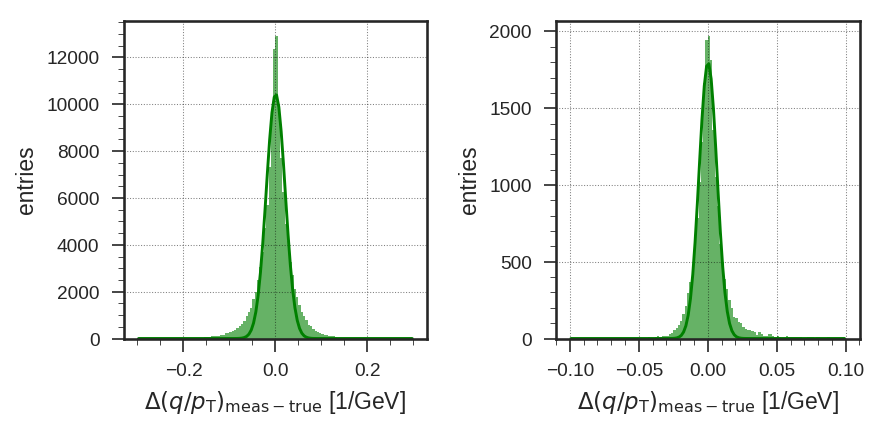

In [20]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 3.313744e-02, std: 1.207835e-01, mse: 2.149987e+00, mae: 1.599842e-01, mad: 1.365486e-01
[INFO    ] gaus fit (a, mu, sig): 9.138286e+03, -1.012503e-02, 1.224759e-01
[INFO    ] # of entries: 20086, mean: 9.689798e-02, std: 1.456976e-01, mse: 1.273698e+01, mae: 3.555420e-01, mad: 2.521353e-01
[INFO    ] gaus fit (a, mu, sig): 8.268398e+02, -3.236946e-02, 2.039943e-01


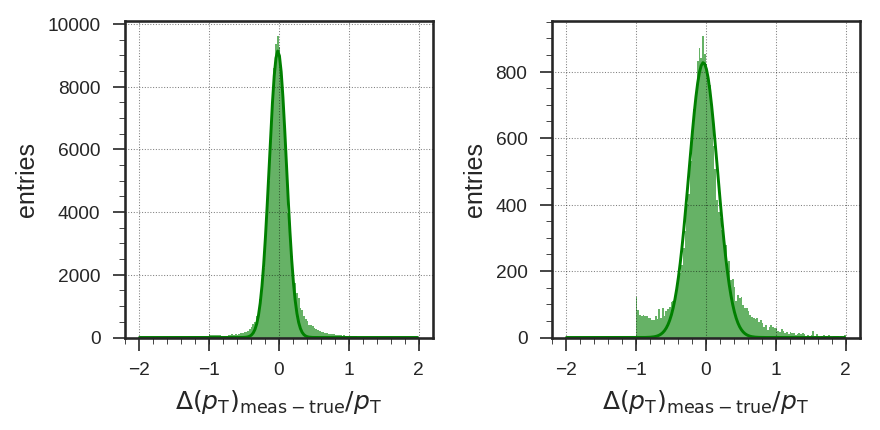

In [21]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred_regr)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

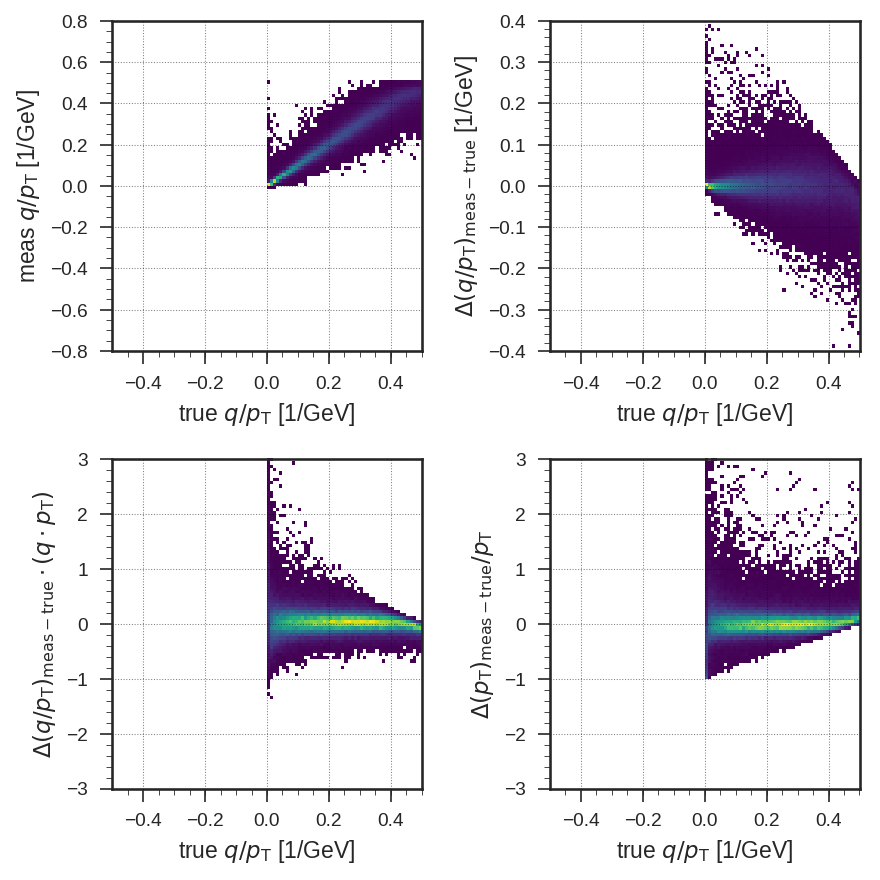

In [22]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred_regr - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,1].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')

yy = (y_test_pred_regr - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,0].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred_regr) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,1].set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')

plt.show()

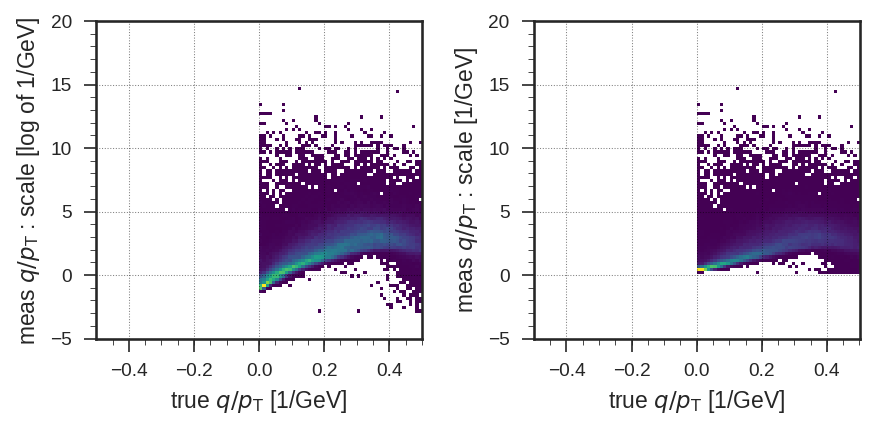

In [23]:
# Plot 'scale'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = y_test_true
yy = 0.01 * y_test_pred_scale_logit
axs[0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [log of 1/GeV]')

xx = y_test_true
yy = y_test_pred_scale
axs[1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [1/GeV]')

plt.show()

In [24]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred_regr) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 8.029356e+01, -2.840363e-02, 1.544405e-01
[INFO    ] gaus fit (a, mu, sig): 7.139158e+01, -2.709554e-02, 1.779543e-01


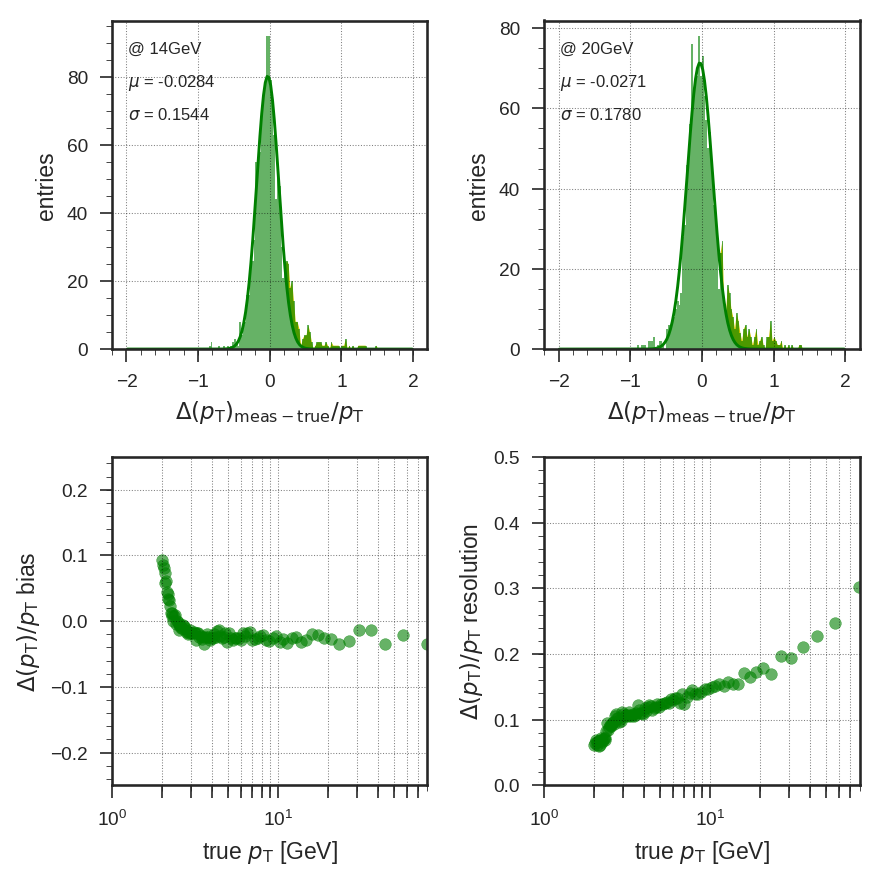

In [25]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
#yy = yy_25GeV
#pt = 25
#doit()
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] high tail prob: 8.869077e-02, 9.817386e-02, 1.071184e-01


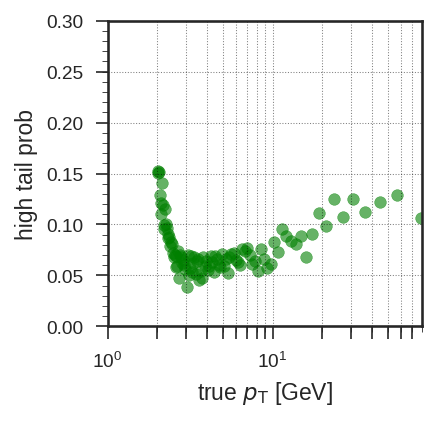

In [26]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail prob')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] coverage # of sigmas: 1.415781e+00, 1.323535e+00, 1.319622e+00


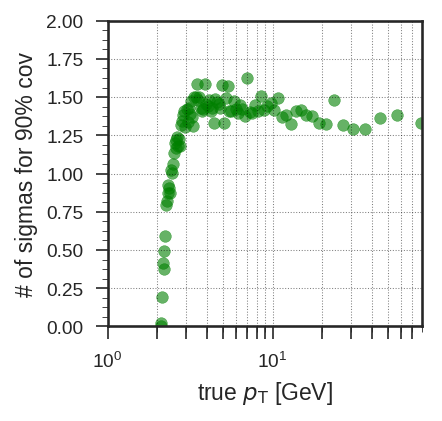

In [27]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'# of sigmas for 90% cov')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

### Check Loss Function

In [28]:
y_train_pred = loaded_model.predict(np.concatenate((x_train, pu_x_train, pu_x_train)), batch_size=4096)
y_train_true = np.concatenate((y_train_tmp, pu_y_train_tmp, pu_y_train_tmp))
if y_train_true.ndim == 1:
  y_train_true = y_train_true[:, np.newaxis]

In [29]:
emlf_loss_2 = partial(emlf_loss,
                      reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale,
                      return_everything=True)
emlf_loss_2.__name__ = emlf_loss.__name__  # needed for Keras save_model()

loss, components = emlf_loss_2(y_train_true, y_train_pred)
#print loss, components

sess = K.get_session()
loss_e, components_e = sess.run([loss, components])
#print loss_e, components_e

In [30]:
y_true0 = components_e[0]
log_prob0 = components_e[1]
masks_lp0 = components_e[2]
log_prob_q0 = components_e[3]
masks_lpq0 = components_e[4]
log_prob_pu0 = components_e[5]
masks_lppu0 = components_e[6]
print loss_e.mean(), -(log_prob0 * masks_lp0 + log_prob0 * masks_lppu0).mean(), \
    -(log_prob0 * masks_lp0).mean(), -(log_prob0 * masks_lppu0).mean()
print -log_prob0[masks_lp0 > 0].min(), -log_prob0[masks_lp0 > 0].max(), \
    -log_prob0[masks_lppu0 > 0].min(), -log_prob0[masks_lppu0 > 0].max()
print y_true0[(masks_lp0 > 0) & (-log_prob0 > 500)], y_true0[(masks_lppu0 > 0) & (-log_prob0 > 500)]

2.6362185 2.6362185 2.1749983 0.46122065
956.4428 -1.625678 685.99854 -2.0359068
[22.844881    7.0763893  13.278      17.244791    0.04109418] [13.288146 14.123186 21.220194 13.288146 14.123186 21.220194]


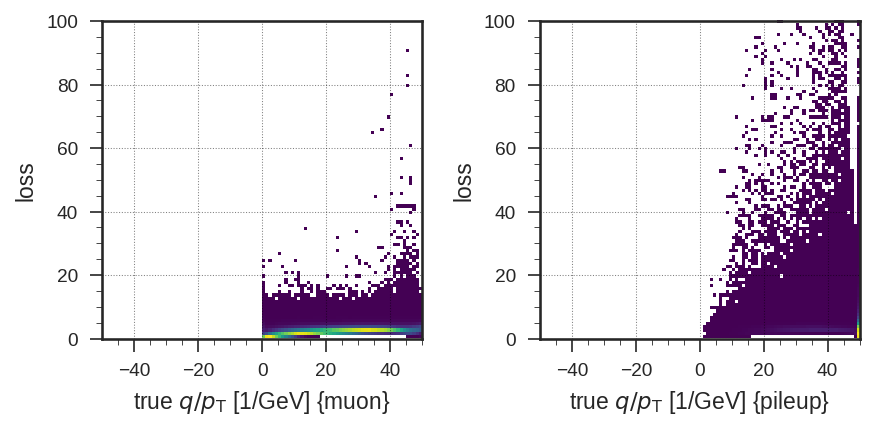

In [31]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

axs[0].hist2d(y_true0[masks_lp0 > 0], -log_prob0[masks_lp0 > 0], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d(y_true0[masks_lppu0 > 0], -log_prob0[masks_lppu0 > 0], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
axs[1].set_ylabel('loss')
plt.show()

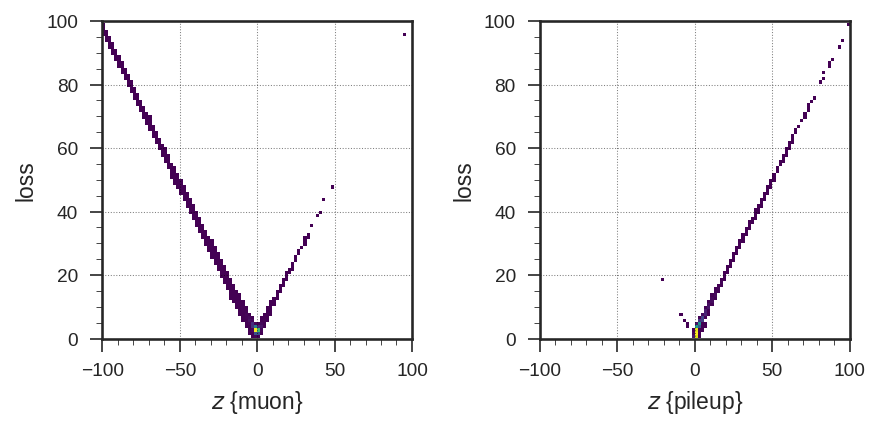

In [32]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#x = np.abs(y_train_true[..., 0:1])
x = y_true0
loc = get_loc(y_train_pred[..., 0:1])
scale = get_scale(y_train_pred[..., 2:3])
standardize = lambda x: (x - loc) / scale

masks_pileup = (y_train_true[..., 3:4] == MASKS.pileup)
masks_pileupx = (y_train_true[..., 3:4] == MASKS.pileupx)

axs[0].hist2d(standardize(x)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-100,100),(0,100)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'$z$ {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d(standardize(x)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-100,100),(0,100)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'$z$ {pileup}')
axs[1].set_ylabel('loss')
plt.show()

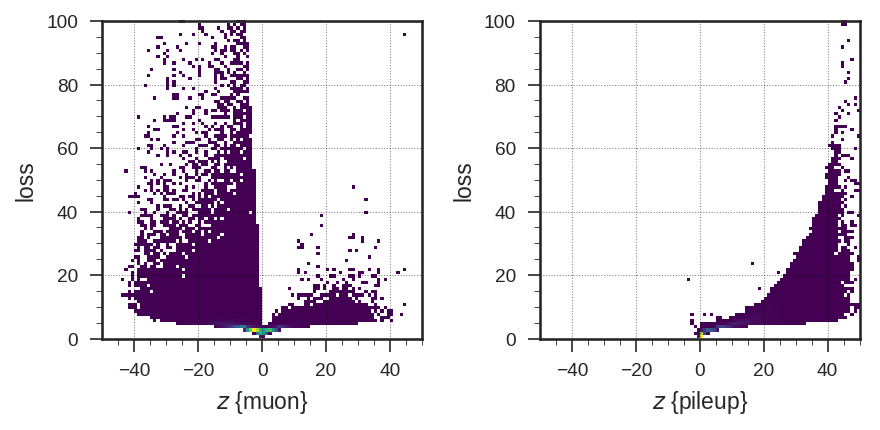

In [33]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#x = np.abs(y_train_true[..., 0:1])
x = y_true0
loc = get_loc(y_train_pred[..., 0:1])
scale = get_scale(y_train_pred[..., 2:3])
standardize_noscale = lambda x: (x - loc)

masks_pileup = (y_train_true[..., 3:4] == MASKS.pileup)
masks_pileupx = (y_train_true[..., 3:4] == MASKS.pileupx)

axs[0].hist2d(standardize_noscale(x)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'$z$ {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d(standardize_noscale(x)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'$z$ {pileup}')
axs[1].set_ylabel('loss')
plt.show()

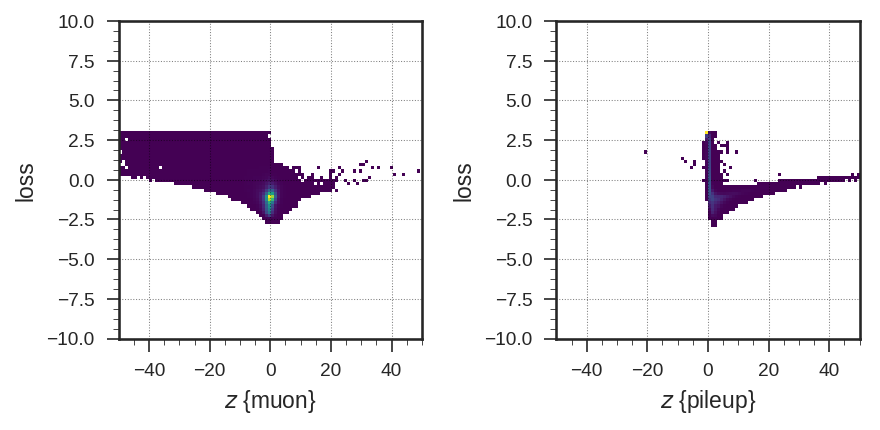

In [34]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#x = np.abs(y_train_true[..., 0:1])
x = y_true0
loc = get_loc(y_train_pred[..., 0:1])
scale = get_scale(y_train_pred[..., 2:3])
standardize_noscale = lambda x: (x - loc)

masks_pileup = (y_train_true[..., 3:4] == MASKS.pileup)
masks_pileupx = (y_train_true[..., 3:4] == MASKS.pileupx)

axs[0].hist2d(standardize(x)[masks_pileup], -np.log(scale)[masks_pileup], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'$z$ {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d(standardize(x)[masks_pileupx], -np.log(scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'$z$ {pileup}')
axs[1].set_ylabel('loss')
plt.show()

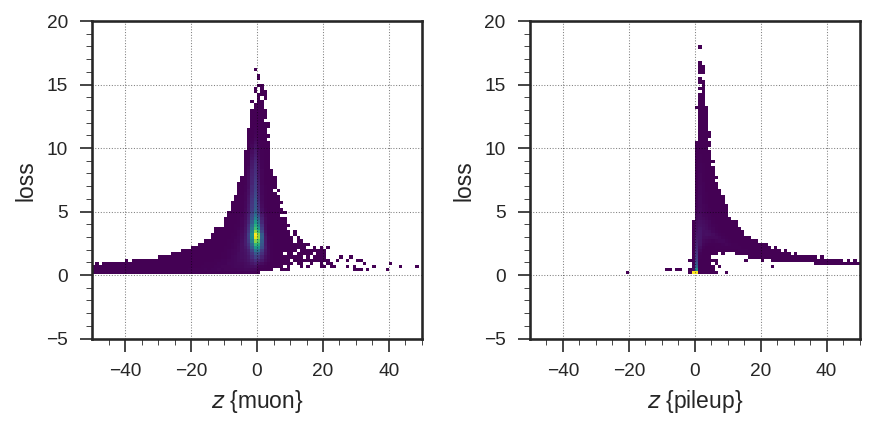

In [35]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#x = np.abs(y_train_true[..., 0:1])
x = y_true0
loc = get_loc(y_train_pred[..., 0:1])
scale = get_scale(y_train_pred[..., 2:3])
standardize_noscale = lambda x: (x - loc)

masks_pileup = (y_train_true[..., 3:4] == MASKS.pileup)
masks_pileupx = (y_train_true[..., 3:4] == MASKS.pileupx)

axs[0].hist2d(standardize(x)[masks_pileup], (scale)[masks_pileup], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'$z$ {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d(standardize(x)[masks_pileupx], (scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'$z$ {pileup}')
axs[1].set_ylabel('loss')
plt.show()

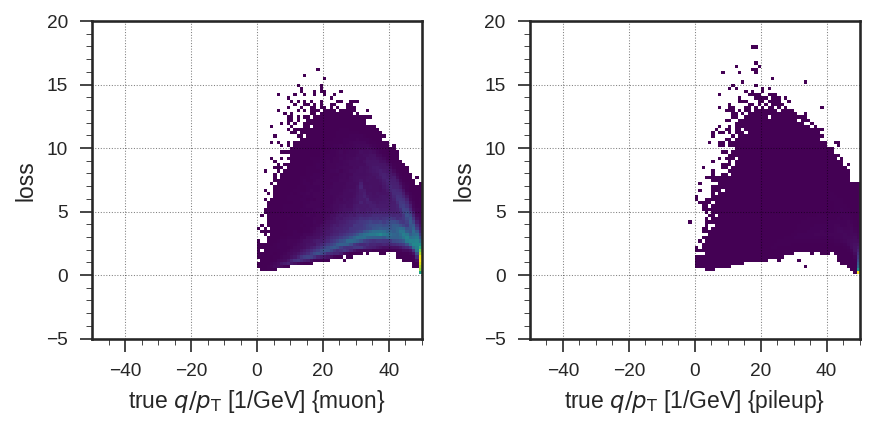

In [36]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

axs[0].hist2d((loc)[masks_pileup], (scale)[masks_pileup], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d((loc)[masks_pileupx], (scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
axs[1].set_ylabel('loss')
plt.show()

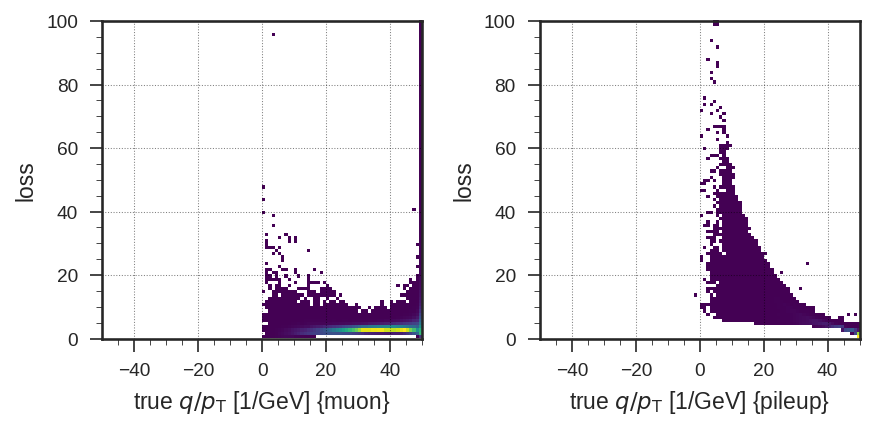

In [37]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

axs[0].hist2d((loc)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {muon}')
axs[0].set_ylabel('loss')
axs[1].hist2d((loc)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
axs[1].set_ylabel('loss')
plt.show()

### Classification Results (1)

### Classification Results (2)

### Regression Results &ndash; displaced muons pT

### Regression Results &ndash; displaced muons d0

### Classification Results (3)

### Efficiency & Rates

In [38]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  lut = np.array([1,3,5,7,9,7,5,3,1,0,2,4,6,8,6,4,2,0], dtype=np.int32)
  return lut[ipt]

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [39]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut_low = 4.
    self.discr_pt_cut_med = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 2.4605,  2.0075,  1.9042,  2.0762,  2.4325,  2.9043,  3.4101,  3.9232,
                  4.4403,  4.9856,  5.5775,  6.2036,  6.8515,  7.5126,  8.1807,  8.8570,
                  9.5343, 10.2031, 10.8651, 11.5340, 12.2164, 12.9187, 13.6537, 14.4093,
                 15.1559, 15.8731, 16.5513, 17.2402, 17.9719, 18.7379, 19.5292, 20.3469,
                 21.1514, 21.9302, 22.6964, 23.4417, 24.1086, 24.7471, 25.4113, 26.1038,
                 26.7868, 27.4820, 28.2311, 29.0478, 29.9305, 30.8285, 31.6537, 32.3950,
                 33.1279, 33.8928, 34.6529, 35.4154, 36.2441, 37.1817, 38.2494, 39.2588,
                 40.1019, 40.8765, 41.6557, 42.4564, 43.2505, 44.0659, 44.9429, 45.8573,
                 46.7469, 47.6586, 48.6987, 49.6689, 50.3389, 50.9753, 51.7242, 52.4922,
                 53.2630, 54.0344, 54.8061, 55.5778, 56.3496, 57.1213, 57.8931, 58.6648,
                 59.4366, 60.2083, 60.9800, 61.7518, 62.5235, 63.2953, 64.0670, 64.8387,
                 65.6104, 66.3822, 67.1539, 67.9256, 68.6974, 69.4691, 70.2408, 71.0125,
                 71.7843, 72.5560, 73.3277, 74.0995, 74.8712, 75.6429, 76.4146, 77.1864,
                 77.9581, 78.7298, 79.5015, 80.2733, 81.0450, 81.8167, 82.5884, 83.3602,
                 84.1319, 84.9036, 85.6754, 86.4471, 87.2188, 87.9905, 88.7623, 89.5340]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      x = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      binx = x.astype(np.int32)
      if binx == bins[0]-1:  # avoid boundary
        binx -= 1
      return binx

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    trg_pt = interpolate(xml_pt, x0, x1, y0, y1)
    assert(trg_pt > 2.)
    return trg_pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg.astype(np.int32)
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)
    strg_ok = (quality2 <= (quality1+1))

    xml_pt = np.abs(1.0/y_pred)

    # Apply cuts
    trigger = (y_discr < 0.)  # default: False
    if self.omtf_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.0% coverage)
        trigger = (y_discr > 0.6043)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.0% coverage)
        trigger = (y_discr > 0.2905)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (98.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    elif self.run2_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (97.0% coverage)
        trigger = (y_discr > 0.8557)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (97.0% coverage)
        trigger = (y_discr > 0.6640)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (97.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    else:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.5% coverage)
        trigger = (y_discr > 0.9600)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.5% coverage)
        trigger = (y_discr > 0.8932)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (99.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (4,))

      y_pred = np.asscalar(y[...,0])
      y_discr = np.asscalar(y[...,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, phi_median, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)

      if passed:
        xml_pt = np.abs(1.0/y_pred)
        pt = self.get_trigger_pt(y_pred)

        trk_q = np.sign(y_pred).astype(np.int32)
        trk = Track(myroad.id, myroad.hits, mode, myroad.quality, zone, xml_pt, pt, trk_q, y_pred, y_discr, phi_median, theta_median)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [40]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred_regr, y_test_pred_discr, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  true_pt = np.abs(1.0/y_true)
  
  eff_data.append((zone, true_pt, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(true_pt), float(xml_pt), float(pt), passed

eff_data = np.asarray(eff_data)

0 6 1.0 26.4465675354 26.3587665558 36.9168590454 [ True]
1 6 1.0 4.25680494308 5.23533773422 5.87218991079 [ True]
2 6 1.0 12.298915863 9.7270860672 11.8439270645 [ True]
3 8 1.0 2.83806705475 2.98675465584 3.39670100985 [False]
4 7 1.0 2.08398747444 2.20349049568 2.62451363173 [ True]
5 8 1.0 3.28855633736 3.07781910896 3.48995796962 [ True]
6 7 1.0 204.229217529 699.647705078 1077.53796802 [ True]
7 8 1.0 2.34633588791 2.35745477676 2.76979432735 [ True]
8 7 1.0 3.22838068008 2.64856958389 3.05459299107 [ True]
9 4 1.0 4.21332979202 3.38335180283 3.80349562006 [ True]
10 6 1.0 4.78337335587 4.24139499664 4.70356538334 [ True]
11 8 1.0 3.92263269424 3.73761892319 4.16894549036 [False]
12 2 1.0 2.17857146263 2.01902508736 2.45045207243 [ True]
13 9 1.0 16.017742157 13.9266138077 17.8645066462 [ True]
14 4 1.0 3.72855401039 3.01529407501 3.42579477978 [ True]
15 8 1.0 11.7609758377 12.5895309448 15.9945397736 [ True]
16 8 1.0 2.7969391346 2.84380745888 3.2520956254 [False]
17 6 1.0 4.4

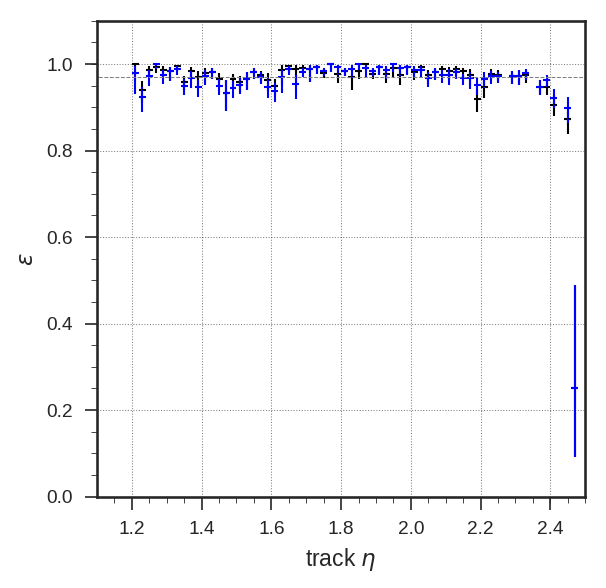

[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 117, 143, 168, 153,
 119, 182, 197, 127, 170, 149, 169, 180,  76, 197, 168, 119, 166, 235, 135,
 175,  68, 182,  86, 230,  80, 140, 256, 102, 132, 253,  98, 134, 107, 304,
 133, 136, 106, 119, 129, 157, 151, 157, 155, 161, 121, 172, 241, 122, 148,
 149, 180, 245,   0, 176, 150, 192,   0, 231, 265, 181,   0, 127,   8,   0]
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  45, 108, 139, 168, 149,
 117, 180, 187, 123, 161, 145, 166, 171,  71, 186, 160, 115, 163, 228, 128,
 164,  66, 180,  82, 226,  79, 139, 252, 102, 131, 249,  97, 134, 106, 299,
 132, 134, 106, 118, 128, 155, 149, 152, 152, 157, 118, 169, 233, 118, 141,
 144, 175, 238,   0, 171, 146, 188,   0, 219, 255, 167,   0, 114,   2,   0]


In [41]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is true_pt
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2

# Old efficiency
color = 'black'
old_denom_hist = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 117, 143, 168, 153,
 119, 182, 197, 127, 170, 149, 169, 180,  76, 197, 168, 119, 166, 235, 135,
 175,  68, 182,  86, 230,  80, 140, 256, 102, 132, 253,  98, 134, 107, 304,
 133, 136, 106, 119, 129, 157, 151, 157, 155, 161, 121, 172, 241, 122, 148,
 149, 180, 245,   0, 176, 150, 192,   0, 231, 265, 181,   0, 127,   8,   0]
old_num_hist = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 110, 141, 167, 151,
 117, 181, 189, 125, 165, 146, 166, 174,  71, 190, 161, 115, 163, 229, 130,
 166,  67, 181,  85, 228,  79, 139, 251, 102, 129, 249,  95, 132, 107, 297,
 132, 133, 105, 116, 128, 154, 150, 153, 152, 159, 119, 170, 237, 119, 136,
 141, 176, 239,   0, 171, 146, 187,   0, 219, 251, 164,   0, 111,   2,   0]
with np.errstate(divide='ignore', invalid='ignore'):
  old_eff_hist = np.true_divide(old_num_hist, old_denom_hist)
yerr = find_efficiency_errors(old_denom_hist, old_num_hist)
ydata = old_eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
#passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
with np.errstate(divide='ignore', invalid='ignore'):
  eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

plt.plot([xlow-0.5,xup+0.5], [0.97,0.97], ls='dashed', lw=0.5, color='gray')
#plt.xlim(xlow-0.5,xup+0.5)
plt.xlim(1.1,2.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

print np.array2string(denom_hist, separator=', ', precision=4, floatmode='fixed')
print np.array2string(num_hist, separator=', ', precision=4, floatmode='fixed')

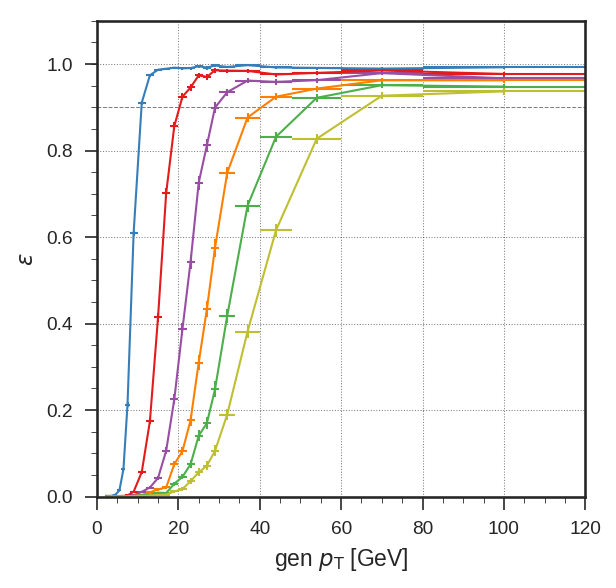

[INFO    ] Eff at 10/20/30/40/50/60 GeV: 0.910815082411, 0.924512987013, 0.934967012253, 0.924528301887, 0.922054915855, 0.926829268293


In [42]:
# Efficiency vs pT
plt.figure()

eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is true_pt
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2

denom_hists = []
num_hists = []
eff_hists = []

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is true_pt
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)
  
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$\varepsilon$')
plt.show()

logger.info("Eff at 10/20/30/40/50/60 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24], eff_hists[5][25]))

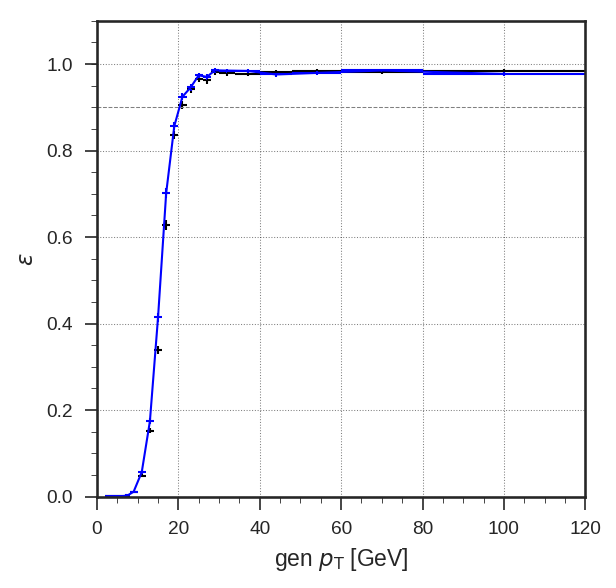

[    0,     0,     0,     0, 30006, 21830, 13460,  9076,  6371,  4725,
  6711,  4429,  3325,  2388,  1853,  1458,  1232,   980,   810,   744,
   626,  1061,  1206,  1166,  1129,  1148,  1094]
[   0,    0,    0,    0,    2,    1,    4,    4,    7,   11,   74,  250,
  578,  989, 1300, 1249, 1139,  927,  789,  722,  617, 1045, 1187, 1138,
 1106, 1131, 1069]


In [43]:
# Efficiency vs pT
plt.figure()

# Old efficiency
color = 'black'
old_denom_hist = [    0,     0,     0,     0, 30006, 21830, 13460,  9076,  6371,  4725,
  6711,  4429,  3325,  2388,  1853,  1458,  1232,   980,   810,   744,
   626,  1061,  1206,  1166,  1129,  1148,  1094]
old_num_hist = [   0,    0,    0,    0,    3,    2,    6,    5,    5,    7,   70,  214,
  507,  808, 1164, 1219, 1116,  923,  783,  716,  615, 1038, 1179, 1145,
 1112, 1127, 1077]
with np.errstate(divide='ignore', invalid='ignore'):
  old_eff_hist = np.true_divide(old_num_hist, old_denom_hist)
yerr = find_efficiency_errors(old_denom_hist, old_num_hist)
ydata = old_eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
with np.errstate(divide='ignore', invalid='ignore'):
  eff_hist = np.true_divide(num_hists[1], denom_hists[0])
yerr = find_efficiency_errors(denom_hists[1], num_hists[1])
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$\varepsilon$')
plt.show()

print np.array2string(denom_hists[1], separator=', ', precision=4, floatmode='fixed')
print np.array2string(num_hists[1], separator=', ', precision=4, floatmode='fixed')

In [44]:
# Find out pT scale factor
xmin = 0.
xmax = 60.
nbinsx = 120
xedges = np.linspace(xmin, xmax, num=nbinsx+1)  # edges used to digitize true_pt

nbinsy = 5  # j = zone0-1, zone2-4, zone5, zone6, all zones

# Each bin contains the threshold for ~90% probability for (zone_special, true_pt)
xxx = np.zeros((nbinsy,nbinsx), dtype=np.float32)

for j in xrange(nbinsy):
  if j == 0:
    sel_j = (0 <= eff_data[:,0]) & (eff_data[:,0] <= 1)
  elif j == 1:
    sel_j = (2 <= eff_data[:,0]) & (eff_data[:,0] <= 4)
  elif j == 2:
    sel_j = (eff_data[:,0] == 5)
  elif j == 3:
    sel_j = (eff_data[:,0] == 6)
  elif j == 4:
    sel_j = (eff_data[:,0] >= 0)

  xx = eff_data[:,1][sel_j]  # true_pt
  yy = eff_data[:,2][sel_j]  # xml_pt
  zz = eff_data[:,4][sel_j]  # discr_passed

  ind = np.digitize(xx, xedges[1:])  # split into mutually-exclusive true_pt bins

  for i in xrange(nbinsx):
    # >>> xedges[:5]
    # array([0. , 0.5, 1. , 1.5, 2. ])
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue

    if 0 <= xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 40:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size

    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90.
    coverage += 0.5 # inefficiency due to fiducial cuts
    #coverage += 1.0 # inefficiency due to fiducial cuts

    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue

    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    xxx[j,i] = pct

    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

14.0 0.0651253663302
14.5 0.0696864111498
15.0 0.0369549150037
15.5 0.03885003885
16.0 0.0
16.5 0.0
17.0 0.0475511174513
17.5 0.100351229303
18.0 0.104493207941
18.5 0.110253583241
19.0 0.118483412322
19.5 0.0609756097561
20.0 0.0641025641026
20.5 0.0704225352113
21.0 0.145772594752
21.5 0.149700598802
22.0 0.160901045857
22.5 0.0839630562552
23.0 0.0874125874126
23.5 0.0
24.0 0.0
24.5 0.0564334085779
25.0 0.0590667454223
25.5 0.0600600600601
26.0 0.0623441396509
26.5 0.0635727908455
27.0 0.0
27.5 0.0692520775623
28.0 0.0716332378223
28.5 0.0734753857458
29.0 0.0768639508071
29.5 0.0788022064618
30.0 0.0796178343949


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

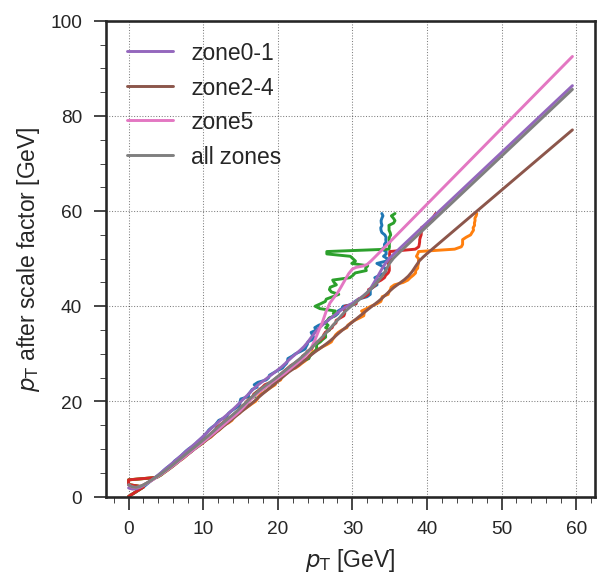

In [45]:
# Find out pT scale factor
plt.figure()

# Before smoothing
xdata = xedges[:-1]
if omtf_input:
  #plt.plot(xxx[0], xdata)
  #plt.plot(xxx[1], xdata)
  #plt.plot(xxx[2], xdata)
  plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
else:
  plt.plot(xxx[0], xdata)
  plt.plot(xxx[1], xdata)
  plt.plot(xxx[2], xdata)
  #plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
plt.xlabel(r'$p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$p_{\mathrm{T}}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')

# After smoothing
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if omtf_input:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')
else:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[4:]))

plt.ylim(0,100)
plt.show()

In [46]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for jevt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred_regr, pu_y_test_pred_discr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  #true_pt = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  highest_part_pt = highest_part_pt if highest_part_pt > 0 else np.nan
  highest_track_pt = highest_track_pt if highest_track_pt > 0 else np.nan
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  if passed and highest_part_pt < 14 and pt > 40.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt),
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          if omtf_input:
            tmp = np.arange(2) * nlayers1 + lay
          else:
            if 0 <= lay <= 4:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1, 2 * nlayers1 + 6]) + lay
            elif lay == 11:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1 - 6, 2 * nlayers1]) + lay
            else:
              tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2937 11.6057 18.0000 7 [51.32990077] [1.]
  39 5390  4.1569  5.0000 5 [41.18562194] [1.]
  40 2186  7.5850 30.5000 4 [335.02842485] [1.]
.... 0 [-60.  42. -15.   6.]
.... 1 [0. 0. 0. 0.]
.... 2 [ 0. 42. -1.  6.]
.... 3 [0. 0. 0. 0.]
.... 4 [18. 41.  0. -6.]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 0.]
.... 8 [0. 0.]
.... 9 [0. 0.]
.... 10 [ 2. 40.]
.... 11 [0. 0. 0. 0.]
  40 4388  3.3931  5.0000 4 [48.61737077] [1.]
  42 4409  3.8925     nan 6 [215.46602925] [1.]
.... 0 [0. 0. 0. 0.]
.... 1 [0. 0. 0. 0.]
.... 2 [19.  8. -2. -6.]
.... 3 [3. 8. 1. 5.]
.... 4 [-1.  8.  0.  5.]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 8.]
.... 8 [2. 9.]
.... 9 [0. 0.]
.... 10 [0. 0.]
.... 11 [-4. 17. -8.  4.]
  54 6419  7.5854 41.5000 8 [74.34275224] [1.]
  55 2596  7.9947 40.0000 8 [67.51092429] [1.]
  58  608  2.4815  5.5000 4 [46.8965036] [1.]


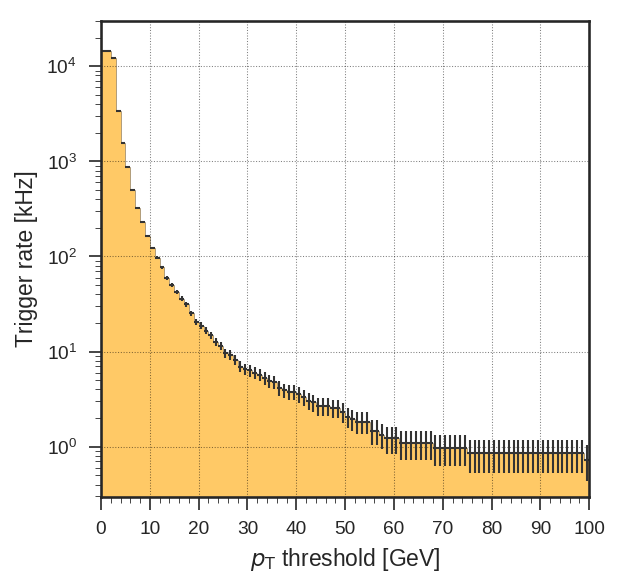

[INFO    ] nevents: 258400/498400
[INFO    ] Rates at 18/20/22/25/30 GeV: 25.2972335666, 18.8201640695, 14.9094805568, 9.6544996351, 6.3548604846


[1.4317e+04, 1.4317e+04, 1.2211e+04, 3.3554e+03, 1.5546e+03, 8.6292e+02,
 5.0436e+02, 3.2275e+02, 2.3024e+02, 1.6486e+02, 1.2270e+02, 9.7278e+01,
 7.6869e+01, 5.9760e+01, 5.0228e+01, 4.2284e+01, 3.6174e+01, 3.1652e+01,
 2.5297e+01, 2.0653e+01, 1.8820e+01, 1.6620e+01, 1.4909e+01, 1.2710e+01,
 1.1488e+01, 9.6545e+00, 9.2879e+00, 8.1880e+00, 6.9659e+00, 6.5993e+00,
 6.3549e+00, 5.9882e+00, 5.7438e+00, 5.2550e+00, 4.8884e+00, 4.7661e+00,
 4.1551e+00, 3.9107e+00, 3.7885e+00, 3.7885e+00, 3.5441e+00, 3.2996e+00,
 3.0552e+00, 2.9330e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00,
 2.5664e+00, 2.3220e+00, 2.0776e+00, 1.9553e+00, 1.8331e+00, 1.8331e+00,
 1.8331e+00, 1.4665e+00, 1.4665e+00, 1.3443e+00, 1.2221e+00, 1.2221e+00,
 1.2221e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00,
 1.0999e+00, 1.0999e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.

In [47]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > 1e-7]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be approx half the statistics
logger.info("Rates at 18/20/22/25/30 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[20], hist[22], hist[25], hist[30]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

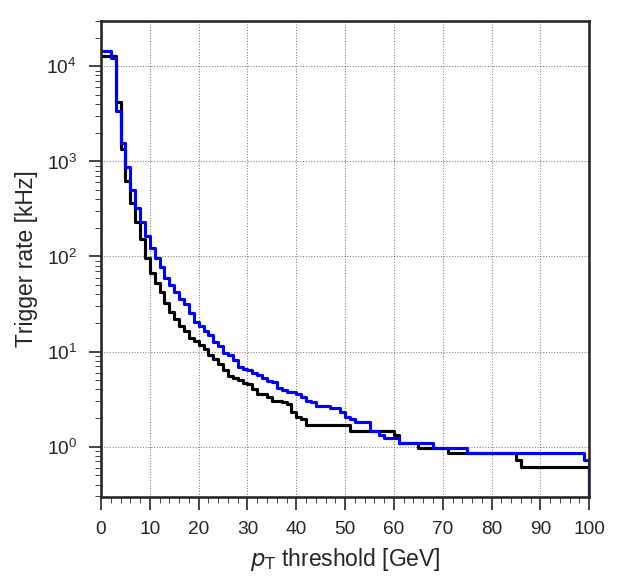

In [48]:
# Old rates
old_hist = [1.2879e+04, 1.2879e+04, 1.2879e+04, 4.2422e+03, 1.3642e+03, 6.1605e+02,
 3.6455e+02, 2.3159e+02, 1.5411e+02, 9.5812e+01, 6.6970e+01, 5.2672e+01,
 4.2162e+01, 3.2752e+01, 2.6397e+01, 2.1998e+01, 1.8820e+01, 1.6376e+01,
 1.4054e+01, 1.2954e+01, 1.1854e+01, 1.0632e+01, 9.1657e+00, 8.3102e+00,
 7.3325e+00, 6.4771e+00, 5.4994e+00, 5.2550e+00, 5.0106e+00, 4.6439e+00,
 4.5217e+00, 4.0329e+00, 3.5441e+00, 3.5441e+00, 3.2996e+00, 3.0552e+00,
 3.0552e+00, 2.9330e+00, 2.8108e+00, 2.3220e+00, 2.0776e+00, 1.9553e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.3443e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 7.3325e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
steps = np.append(np.array(old_hist), 0.)
plt.step(edges, steps, where='post', color='k', lw=1.5)
steps = np.append(np.array(hist), 0.)
plt.step(edges, steps, where='post', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

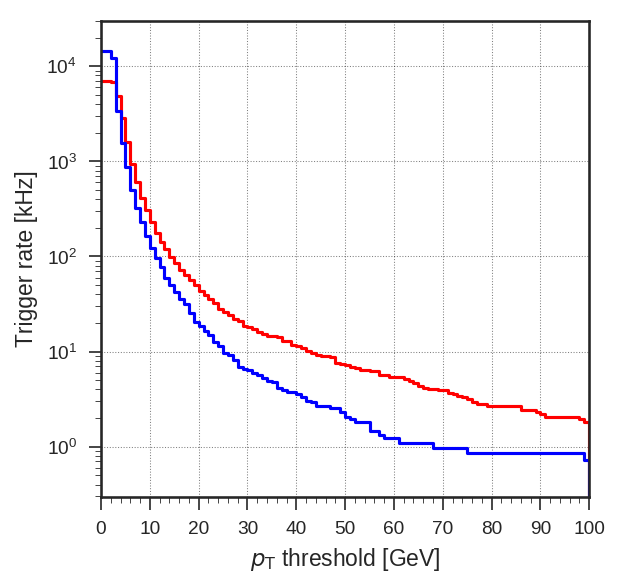

In [49]:
# Reference EMTF rates
old_hist = [7.0348e+03, 7.0348e+03, 6.7679e+03, 4.9052e+03, 2.8801e+03, 1.5997e+03,
 9.3649e+02, 6.0726e+02, 4.1551e+02, 3.0552e+02, 2.2865e+02, 1.7781e+02,
 1.4237e+02, 1.1940e+02, 9.9600e+01, 8.4569e+01, 7.1859e+01, 6.3182e+01,
 5.6338e+01, 4.9617e+01, 4.3262e+01, 3.9473e+01, 3.5929e+01, 3.2141e+01,
 2.8352e+01, 2.6153e+01, 2.4197e+01, 2.2242e+01, 2.0776e+01, 1.8820e+01,
 1.8209e+01, 1.7231e+01, 1.6254e+01, 1.5154e+01, 1.4665e+01, 1.4543e+01,
 1.4176e+01, 1.3076e+01, 1.2832e+01, 1.1854e+01, 1.1365e+01, 1.0999e+01,
 1.0143e+01, 9.7767e+00, 9.2879e+00, 9.0435e+00, 8.9212e+00, 8.6768e+00,
 7.5769e+00, 7.3325e+00, 7.2103e+00, 6.8437e+00, 6.7215e+00, 6.3549e+00,
 6.3549e+00, 6.2327e+00, 6.2327e+00, 5.7438e+00, 5.7438e+00, 5.3772e+00,
 5.3772e+00, 5.3772e+00, 5.1328e+00, 4.8884e+00, 4.6439e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 4.0329e+00, 3.9107e+00, 3.9107e+00, 3.6663e+00,
 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00, 2.9330e+00, 2.8108e+00,
 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00,
 2.6886e+00, 2.6886e+00, 2.4442e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00,
 2.1998e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00,
 2.0776e+00, 2.0776e+00, 1.9553e+00, 1.8331e+00]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
steps = np.append(np.array(old_hist), 0.)
plt.step(edges, steps, where='post', color='red', lw=1.5)
steps = np.append(np.array(hist), 0.)
plt.step(edges, steps, where='post', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

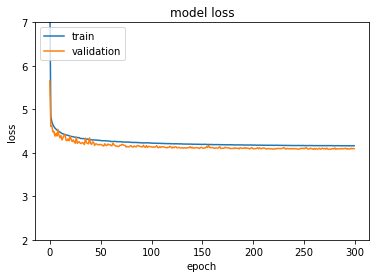

In [50]:
# Training history
# 2019-06-27

"""
[INFO    ] Done training. Time elapsed: 2:45:42.233456 sec
[INFO    ] Epoch 300/300 - loss: 4.16373185956 - regr_loss: 3.32120957551 - discr_loss: 0.0421261143613 - val_loss: 4.09427099966 - val_regr_loss: 3.26545494275 - val_discr_loss: 0.0414408028216
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XmcFdWd9/HP7269NzTQ7MjiRssiICIGMSrGuMZdTNSJZhISJ4n6mkzmwewzT8zkmSRq4hgTTcyYxCUGQzSJ0YgBl6goICKrC4IsAs3SdDe93eU8f5zqpsFegdvLvd/368Wr71K36lQV91unTp0615xziIhI5gt1dwFERKRrKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfBDCz/zWz73Zw2g1mdvbhzkekqynwRUSyhAJfRCRLKPCl1wiaUr5qZm+aWbWZ3W9mg8zsr2ZWaWYLzKyk2fSfMLNVZlZhZovMrKzZe5PNbJmZVZnZ74Dcg5Z1oZktDz77kplNPMQyf87M3jGz3Wb2hJkNDV43M7vDzHYEZX/TzMYH751vZquDsm0xs387rA0nElDgS29zOXA2cDxwIfAU8DVgYPD/+SZ8aB4HPAzcApQCTwJ/MrOYmcWAPwK/AfoBvw/mS/DZycD9wOeB/sDPgSfMLKczBTWzs4D/Aq4ChgAbgUeCt88BTgeOA/oE0+wK3vsl8HnnXBEwHvj7kdyAkr0U+NLb3OWc2+6c2wK8ALzinHvdOVcHzAcmB9PNBv7inHvGORcHfgjkAR8BpgNR4E7nXNw5Nw94rdky5gA/d84tds4lnXMPAPXB5zrjGuB+59wy51w9cCtwqpmNAuJAETAWMOfcGufcB8Hn4sAJZlbsnNvjnFt2hLadZDkFvvQ225s9rm3heWHweGhQowbAOZcCNgHDgve2uANHDtzY7PFI4CtBc06FmVUAI4LPdcbBZagOavHDnHN/B/4HuBvYYWb3mllxMOnlwPnARjN7zsxO7eRyRVqkwJdMtTUIbgjazIPQ3gJ8AAwLXmt0VLPHm4DbnHN9m/3Ld849fJhlKAiaiLbgDwA/cc6dBJwQNO18NXj9NefcxUEz1R+BRw9jO4g0UeBLpnoUuMDMZplZFPhK0CzzEvAykABuMrOomV0GTGv22fuAL5jZKcHF1QIzu8DMijpZhoeBG8xsUtD+/z1gsXNug5mdHMw/CuwD6oBUcI3hGjPrEzRFVQKpI7xtJEsp8CUjOefWAdcCdwE7gYuAi5xzDc65BuAy4Hpgd9De/4dmn10CfC5octkDvBNM29kyLAC+CTwWnFUcDVwdvF0cHFj2BM0+u4AfBO9dB2wws0rgC8G1AJHDZvoBFBGR7KAavohIlkhb4JvZ8cGNK43/Ks3slnQtT0RE2tYlTTpmFg56JpzinNvYgY+IiMgR1lVNOrOAdxX2IiLdJ9JFy7k66KL2IWY2J7izkYKCgpPGjh3b6Zlv2LmPRMpxzMDCDkwtIpI5li5dutM5V9qRadPepBOMW7IVGOec297WtFOnTnVLlizp9DI+87+vUV5Vz5++fNrhFFVEpNcxs6XOuakdmbYrmnTOA5a1F/aHI2SQUvdSEZE2dUXgf7K15pwjxcxIKe9FRNqU1sAPxg75WPO7GNMhZKAbyERE2pbWi7bOuX3BYFGHLB6Ps3nzZurq6lqd5rqxURKpItasWXM4i8oKubm5DB8+nGg02t1FEZEu1lW9dA7Z5s2bKSoqYtSoURw4uOF+G3ftoy6e4vjBnR3bKrs459i1axebN29m9OjR3V0cEeliPX5ohbq6Ovr3799q2AO0/o40Z2b079+/zbMlEclcPT7wCYKqnSkAteF3RPvbUkQyVa8I/PaYKe5FRNqTEYEP6avgV1RU8NOf/rTTnzv//POpqKhIS5lERA5F5gR+mrQW+IlEos3PPfnkk/Tt2zeNJRMR6Zwe30unI9LZgj937lzeffddJk2aRDQaJTc3l5KSEtauXctbb73FJZdcwqZNm6irq+Pmm29mzpw5AIwaNYolS5ZQXV3Neeedx2mnncZLL73EsGHDePzxx8nLy0tTiUVEWtarAv8//rSK1VsrP/R6fSJFMuXIj4U7Pc8Thhbz7YvGtfr+97//fVauXMny5ctZtGgRF1xwAStXrmzq1nj//ffTr18/amtrOfnkk7n88svp3//AWw/efvttHn74Ye677z6uuuoqHnvsMa699tpOl1VE5HD0qsDvCaZNm3ZAH/af/OQnzJ8/H4BNmzbx9ttvfyjwR48ezaRJkwA46aST2LBhQxeXWkSklwV+azXxLXtq2Fub4IShxWkvQ0FBQdPjRYsWsWDBAl5++WXy8/M544wzWuzjnpOT0/Q4HA5TW1ub9nKKiBwsQy7apq9veVFREVVVVS2+t3fvXkpKSsjPz2ft2rW88soraSuHiMjh6lU1/FYZuDRdtu3fvz8zZsxg/Pjx5OXlMWjQoKb3zj33XH72s59RVlbG8ccfz/Tp09NSBhGRI6FLftO2o1r6AZQ1a9ZQVlbW5ue2VtSyp6aBcUP7pLmEmaEj21REeoee9gMoXaPnHLdERHqkjAh8jaQjItK+jAh8DZcpItK+zAh81fBFRNqVEYGvCr6ISPsyIvCDfpkiItKGDAn89PXD76zCwkIAtm7dyhVXXNHiNGeccQYHdz892J133klNTU3Tcw23LCKHKyMCv/FHnHrSPQVDhw5l3rx5h/z5gwNfwy2LyOHKiMBPp7lz53L33Xc3Pf/Od77Dd7/7XWbNmsWUKVOYMGECjz/++Ic+t2HDBsaPHw9AbW0tV199NWVlZVx66aUHjKVz4403MnXqVMaNG8e3v/1tCAZk27p1K2eeeSZnnnkmBMMt79y5E4Dbb7+d8ePHM378eO68886m5ZWVlfG5z32OcePGcc4552jMHhE5QO8aWuGvc2Hbmx96uSSZoiCRgpxw5y/hDp4A532/1bdnz57NLbfcwhe/+EUAHn30UZ5++mluuukmiouL2blzJ9OnT+cTn/hEq78Xe88995Cfn8+aNWtYsWIFU6ZMaXrvtttuo1+/fiSTSWbNmsWKFSu46aabuP3221m4cCEDBgw4YF5Lly7lV7/6FYsXL8Y5xymnnMJHP/pRSkpKNAyziLRJNfx2TJ48mR07drB161beeOMNSkpKGDx4MF/72teYOHEiZ599Nlu2bGH79u2tzuP5559vCt6JEycyceLEpvceffRRpkyZwuTJk1m1ahWrV69uszwvvvgil156KQUFBRQWFnLZZZfxwgsvgIZhFpF29K4afis18YqqOrbtrWP80D5Y6Mh30rzyyiuZN28e27ZtY/bs2Tz44IOUl5ezdOlSotEoo0aNanFY5Pa89957/PCHP+S1116jpKSE66+//pDm00jDMItIWzKiht8Y8em6ZDt79mweeeQR5s2bx5VXXsnevXsZOHAg0WiUhQsXsnHjxjY/f/rpp/PQQw8BsHLlSlasWAFAZWUlBQUF9OnTh+3bt/PXv/616TOtDcs8c+ZM/vjHP1JTU8O+ffuYP38+M2fOPOLrLCKZp3fV8FuV3luvxo0bR1VVFcOGDWPIkCFcc801XHTRRUyYMIGpU6cyduzYNj9/4403csMNN1BWVkZZWRknnXQSACeeeCKTJ09m7NixjBgxghkzZjR9Zs6cOZx77rkMHTqUhQsXNr0+ZcoUrr/+eqZNmwbAZz/7WSZPnqzmGxFpV0YMj1xeVc8He2sZN7SYcCgjTlrSSsMji2SOrBseualJp+ccu0REepyMCHwNpiMi0r5eEfjtNTul+6JtJulJTXgi0rV6fODn5uaya9cuBdUR4Jxj165d5ObmdndRRKQb9PheOsOHD2fz5s2Ul5e3Os2++gR7auKE9uYSTkM//EySm5vL8OHDu7sYItINenzgR6NRRo8e3eY0j7z6PnOfeJOXbz2LIX3yuqpoIiK9So9v0umIUDCGTUqtPiIirUpr4JtZXzObZ2ZrzWyNmZ2anuX4vyklvohIq9LdpPNj4Cnn3BVmFgPy07GQxhq+ruuKiLQubYFvZn2A04Hr8T1EGoCGdCyr8ebalBJfRKRV6WzSGQ2UA78ys9fN7BdmVnDwRGY2x8yWmNmStnritKWxhp9U4IuItCqdgR8BpgD3OOcmA/uAuQdP5Jy71zk31Tk3tbS09JAWtL9JR4EvItKadAb+ZmCzc25x8HxecAA44tRLR0SkfWkLfOfcNmCTmR0fvDQLaPvnnA5R471WasMXEWldunvpfBl4MOihsx64IR0Lafwt2VQqHXMXEckMaQ1859xyoEPjNB8O1fBFRNqXUXfaKu9FRFqXGYGvfvgiIu3KiMBvasNX4IuItCojAj+kwBcRaVdGBH5Y/fBFRNqVEYEf0miZIiLtyojAN9XwRUTalRGB31jD11g6IiKty4jAP+aFm7ks9Lxq+CIibciIwO+76e+Uhd5XLx0RkTZkROC7cJQoCQW+iEgbMiPwQ1FiCnwRkTZlTOBHSWi0TBGRNmRG4IejRCypGr6ISBsyIvAJxYI2/O4uiIhIz5URge/Cvg1f/fBFRFqXEYFPYxu+8l5EpFUZEfguHCWC2vBFRNqSEYFPOErM1C1TRKQtGRH4Lrhoq7wXEWldRgQ+wZ22STXii4i0KmMCX234IiJty5DAjwXdMru7ICIiPVeGBL4GTxMRaU9GBL6FokQtqX74IiJtyIjAd5EYEdXwRUTalBGBb01t+Ap8EZHWZETgE44RRU06IiJtiXR3AY4EC0fUpCMi0o7MqeFbkmRSv4AiItKajAh8C8f831Siu4siItJjZUbgR3zgk2zo7qKIiPRYmRH44aj/m4p3d1FERHqsjAh8Gmv4CnwRkValtZeOmW0AqoAkkHDOTU3LcoI2/JCadEREWtUV3TLPdM7tTOcCQhFdtBURaU9GNOk0tuGTUg1fRKQ16Q58Bywws6VmNqelCcxsjpktMbMl5eXlh7QQdcsUEWlfugP/NOfcJOA84ItmdvrBEzjn7nXOTXXOTS0tLT20pTQGvtrwRURaldbAd85tCf7uAOYD09KyIHXLFBFpV9oC38wKzKyo8TFwDrAyLQsLAj+kwBcRaVU6e+kMAuabWeNyHnLOPZWWJTW14SvwRURak7bAd86tB05M1/wPoBq+iEi7MqJbpmr4IiLty4zAD/kafl1dXXeXRESkx8qMwA+adLbvqe7ukoiI9FgZEvi+SWd3ZRUNCf0IiohISzIq8EMuwbvlquWLiLQkQwLfN+lESbB6a2V3l0ZEpEfKqMDPC6dYsbmiu0sjItIjZUjg+yadY/vn8NSqbSRTrrtLJCLS42RG4AfdMscNzmN7ZT2L39vV3SUSEelxMiTwQ2BhxpTEKIiFeWjx+91dIhGRHqdDgW9mN5tZsXm/NLNlZnZO+ovXCS5J9KXbuXvUC/x5xQes3LK3u0skItKjdLSG/xnnXGUw4mUJcB3w/TSXrXP6HQ3Aaakl9CuI8a3HV6otX0SkmY4GvgV/zwd+45xb1ey1nuELL8KEK4lUbuKbF5ax7P0Kfvbcu91dKhGRHqOjgb/UzP4WBP7TwTj3PeuW1lg+DDwBKrdwSVkRF04cwg+eXsfdC9+Bivehekd3l1BEpFt1dHjkfwYmAeudczVm1g+4Ic1l67zSsQBY+VvcMfskwiHjB0+v47JXv83Ao44j/MmHuruEIiLdpqM1/FOBdc65CjO7FvgG0POuipYe7/++9BOilZu4/apJfObU4fSvWc+utxazdpvuwhWR7NXRwL8HqDGzE4GvAO8Cv05z2TqvZJT/u+YJePprhEPGt04rJGZJBrqdfOquZ7jv+fWkdDFXRLJQRwM/4ZxzwMXA/zjn7gaK0ly2zguF4bJf+OvJW1+Hhn2wff/P6F41sprbnlzDJ+97hXd2aJA1EckuHW3DrzKzW4PumDPNLARE01y2QzPxSti3A57+Gtw9Hfbuvwnr/0xOMmbyRP7vn1dz9u3PMX5YMRdNGMJFE0oZ2r9PtxZbRCTdOlrDnw3UB/3xtwHDgR+kuWyHbthJ/m+zsCdWhJWv4apjYeHnj+UbF5QxKrWJKxaewTs/voBLf/oP/vuptbz0zk7iyZ7VAUlE5Egw31LTgQnNBgEnB09fdc4d8X6OU6dOdUuWLDn8GTXUwH8Nh1gh1AfXlkee5mv+LgUFA+GGJ+Gej8CO1QBcUfonlm+pJpFynFq4g0+PTZEz/iKOGVjI8JI8zHrWbQciIvhsXuqcm9qRaTvUpGNmVwU1+kXBDVd3mdlXnXPzDru06RDLh8nXwMBx0FDtL+Ym6uHxf/HvV7wPbz3tw37UTNjwAvNmD2Ff0WheeLuckiduYNKbrzF1STFV5DOwKIeTR/Xj7KKNTKxYwO6Z/8nI/gUU50XJjYa7e21FRDqko234XwdObqzVm1kpsADomYEP8Im7DnzeUANP3wp1eyHZAH/5iq/pz/oW/PJjsH0VBQOO5dxxg3F/fRdrSPDEOVW8mD+NpRt289qGPUyv/i1HRxbwydWnsoMS8mNhbj1vLGNKCxlQmIMZHJ23j/A/7oCz/wOiuVC5FR77HFz+Cyge0l1bQ0Skw4EfOqgJZ1evG2kzlg+X3Qe1FTB/DlRuhjO/DoMngIVg+yqo2QVvPYXt86s6esezjL76M1w3fSQAiV/+ADbBvecV8mZsHI8v38o3H191wGL+OefvfNN+wY83jmRZbCpzil9hxsYX2b78KQbOvF5NQyLSbToa+E+Z2dPAw8Hz2cCTaSxXehz3cf934XehajtM/QxE86DfGFj7F9i5DlIJP83I0+Dtv8HLd8OWZXDZvUR2vQXApNwdTDplFFdPO4pVWyupbUiys7qeeDLFkJfnQzmU7FnBe+EyVq1/hRkReOJvf+OOBUMYUZJPTTxB37wYg4pzyImEiYaNcUP7MLhPLvmxcNPj2oYkZqjZSESOiA4FvnPuq2Z2OTAjeOle59z89BYtjU7/qm/TLxjgnw8/Gd54GPL6Qe1u/9qFd8Dd03z3zsZpanb6xzvXARANh5g0ou+B8161C8rhn0bs5NpPnUHtr+6ETXDRoJ1sGTmCzXtqKMiJUFETZ0tFHQ2JJHXxFH9cvvWA2URCRiK4Qax/QYxoOER+TpjSwhyKciNMH9OfowcWEg2FMIMP9taRHwtz3KAiSgtzmoa2y4mEyImEdGYhIh3vpdMVjlgvnc5K1MO2lf4AULsH9m6Gsgvh99fD2ieheCjsec9Pa2EoGgJDJsKud+DTf4acQnj/FRhzJvx4Iuzd5A8e/74e7hgHlVv88y8tgSe+DP2PhjNu9c1MgfKqeipqGqisi7N80152VtdTlBvBOdi0u4ZkylHTkGRHVR17auKdunGsKCfCyAH5/jqDvwYT/AUwCnPCjB1STEl+lPpEirIhxWytqCU3GqYwJ0JhToQ+eVH65kcpyo0SDrV88HDO6cAi0sU600unzcA3syqgpQnMf79d8eEU9GDdFvitiddC1TYf9r+51L82dApsXQa5ffz7R58FiTpYvwhGTIdNr0Dfo3xPoBk3wz9+DMXD/TWDKZ+GZQ/4+Xz8e3DqFw+5aG9u3kttPEnR+8+SyOtP0ZhTqK5PsG5bFRW18abp6uJJdlTW8d6uGipqGnAOHM7/DfZsRU0DW/fWdWi5ZlCcG6VPXpRYJMSOyjr65EeprE1QXZ/gmNJCImEj5eDE4X2amqQaEinyY2H65scozo1Q05AkFgnRJy9KcW6U6voE+bEwQ/vmEYuEiCdTFOdGSaYcSefIj4XpX5BDNGxBOYxEMoWZtXoAEskGRyzwu1qPC/zmXroLVj8BU67ztfTPPw/rn4Nnvunfn3wtvP5b//jin8K6J2Htn/3zj86F54Lfizn2477G71KQVwJ1lfDRr8KA4/0ZxpZlMOREKBrkDyj3fxwmzobp/wILvwd9R8CwqdBvtO9t9MPj/Y+4f+EFKBnZctnL3/L3IIyc0Vit/5CKmgYqauIkneOdHdWMGVBAfSLFvnof5Htr41TUxKmojbO3poGK2ji1DUkGFedSVRenOC9KXjTM2zuqMSCecry+cQ850RC1DUlyomFqGhLUxQ/9prZwyAgZREIhomGjsi6BmW/yioRChEOGc45EynF0cOAJh4xIyPz7YSMaMsKhECnncM4xprSQvbVxImEjJxwiGg4RCvnPhc2Iho2BxbnEkylqGpLUNCRJJFMcN6iInGiIeNKRco4BBTlU1sUpyIkwoDBGOGTsqm6gICdCTUOC4twoRbkRDMNCEDIjFg4Ri3y470Nd3F+7yYno2o20T4GfbskEhIPLH7ve9eE94FjfBLRqPnxpKQw4BrYs9f39T/tXeP03sOA7cM3v4b0XYNH3IJrv7xEIbv5qEiuC0//NB/nTt/ofaT/5s7D4nv3TDDwBxl0KC2+DSK5vdrr6YRg4dv807y70TU2L7/HdUUec4s8yRp7qL1R3hHN+HfP7+X+N4rX+ovbxF/htkaiHSE67s6trSFBZn6AgFqEhkaKiNk5lbbwpGLdW1JFIpYiEjIqaONFwiEjY2FefZGtFLYmUoyGRIplK0Tc/hnOO8up6Ekl3wB3Sm/fUknSOZMqRSPq/8VSq6bkZxJMptlfWkxcNk3R+vp010rax0Q065N8Diob9waiRw1EXT/kDWzhEJGQMKvYX8+sTKT/wn/kDRmOzXCg4iOfHwvQriJFI+W0RMqNvfoydVfVU1cebmubyomGq6xPEk46xg4uoqvcdFULBvBr/RSNGNOS3vzVbP3fQSf+Awhycc1TWJXDOEQ0OnNGIL3/YLDiI7p+/P3gHB9bg9XCzaf1z/3rjgXZAYaxpXWvjSeriSUb1L6CqLkFuNIQDUs7v30TKH9DzYxHyY+HW6jkH6GgUlhblEA2HqI0nqWlIEDILrpX5Dhj1iRRmEAuHSKQc9YkUYTNyo/5amnOOhmSKaMhXLlIpR1V9gj55hzZajQK/u6SSPrwHT2jl/ZT/wfXyt+CeU+H8H8KJV8OS+yGnGKq3w4Dj/AXkdUEnqEET/HWFys2+hn7KF/w1ggX/Acl6GDQeLvgR/O46iNf4i8t9j/LXGJ78d3BJ6DMCTvk8vHKPP7uIFcHnnoWcIn+gePY/4R8/8cNLX/sYbHrVl+HMr/uzlsX3+K6rJ1wC02+EoZP9xexX7/X3G5SOhXk3wJX/6w8EBaX+LCWn8MD137zEl/Osb/gb42r3QE4fn1rxGn8AbOmb+fYC35tq1IwPv3fI+yqFM//lbOwF1Xh2kEz5WnvKNTaJ1ROLhMiPhX14YLzz/iZy96xj3NNXs2nat1h11DUU50WobUhSXlVPykG/gij76pPkx8LsrY1T25Aghf/Cp4IDzL6G5Id+irMoJ0I8maI+kSKedGyvrKM2niQ3GiJk5uPWEZyl+ABOOdhXn2D3vgZiER+48WSKyto4AwpzKM6LUl3nz9Rq4gmKcqKknOPtHdX0zYs2BVHSOVIpP794MkU8mUKDy3ac2f4DR/PHBB0xCnMj1MdT1MaTTa+lnGNgUS6vfG3WIS5Tgd/z1Vf5wG3Nhhdh+UO+Rj5kImxaDIMn7q9lb1/tu5KOnglHTYe9W+CPX4DKD/w1h1TCN/1c9WsoHAjhKCQa4IM34NcXQ3yfn0/j9YXjzvVnHvn9oeoDSO2/DsCJn/TNTUsfgPpKf8aRSkCswB/kcop8k1Eosr9bK/gL1aNm+LL2P8avU3yfv/5x/o/giS/5ayJ7NkDVVt+sNeo0GDoJjj3Hnx3t3Qwv/NCfRc24xY+IGor6Mq77Kxx1Clxyj593OApHz/JNXc75G98aOed/9ayh2h9gV/4BLr4LKjbBlH/y800l/b0YBaX7v62bX4N95f5aTTTPz+uN3/l7OfJK/EErrwQ+/Se/vrvXw7Apfts0t3kpPPYZvz9n/uv+1xvv/xg65cMHyPY457dLqFnTTzLh91Hzs7FGdZWQW3zQLJpdaHeuxQNuS8OJN06WcrCjqo5IKERxXoSQmT9QJBz1SX8wS6YcqRSk6qtJhsKkLNZ09pVKsf9xs7+Nr6dSjpxoiPxYhN376puWHwuHCYX8mVzf3BDJ2r0kc/oSMt+EFw37s6Z9DQlqGpId3qTtnQg4B9sq60gF15XyYhFwvhZfn0hRF0+SGw37M8pkqqnZLukc1XW+eTQSCtGvIEo8OCsNh3yzYeP9Pp2lwM92u971ITLspAPDoNGq+fDOs/5s4oPlvpY/6zuw8UV48Q4fYLO+BWv+7IP8rG9BJOYD462n/ZDTtbvhIzfBU3Nh48u+5v/Cj3zvo6GTYdsbsPMd3+wzaJwv01GnwOTr4OFP+rOT4uE+uAccB+Mvh/ULfW+p+oN+W2fgCTB8Kiw76CcYjj8/OBOy/X0L+h/r7262kD9wlK+DvL4QzoHtb+7/rIX92Q/BYHs1u32wN1T7M43iYf6Mp/E6TNEQOOFifx2nehvkD/DbZvJ18Obv/YX7Rv2PhfGXwVtP+YNAbh9Y8ydfxlDEnxXtec+H9ZJf+XJYyG+nukp/1vaRL/ttVLHJp+vav/htNfFqH+iFA+G95+HtZ2DCFUFPso1QvhY+WOGvKe1e77fbjJvh77fB4p/5A/tFd/qDm4Vg6a/8gXzilfDGI3DOd/3ylz+0/2z1mLP9gTjZ4A+A/Y6GPsP8ds4f4P9vJON+3dYv8uvpUlA4CIqGQvka//rin/vt+qnf+TPBeE1QGYn57ZeM+/GvEsFZYn2Vn0fj0aV2j9+fDdWwdTkMLPNleubbvnPFp5/wlZ/tq30T6vjLfflDET/90Mm+Z92AY/33Y9kDMOlaP781f4Ljz/PbpaDUX3ObOBtGTNu/X53zlZPcPv6s+Ogz/f9BzDdrJuP+/9XOt/w+LS2Djf+A3e/6M++S0b4ildvHN7VWb4fh03xlZ/BEX2E5BAp86R6Ntd327Nngw+rYc/yXpHDg/vZ/5/wBZc2fYdAJ/ktTWOqbfp6a6+ffb4wPmXGX+gDetBhGnw473/ZfsOJhPhx3veO/sHu3QF2Fnz5W6A+CfUf6UCse6r/4Iz/iQ71ktG/2Wr/Il+PUL8GYM+D5H/jljDnDf0mn3+ib1gZP9MsudownAAALYklEQVR67wUfHLFCWPRfPtAbm/Zqdvub/k7+LPzy49BQ5aeL1/hyn3IjbFnim7zCUXj37weeKYEPxcJBfpnNjZrpP5eo9U11LgX9x8C2N/2227nOB3sqAcd8zG+fRJ2frlFBqT/YRQv2n/mFc/yBuHytD6m+I/008Rr/fp+j/Gi0xcN8gG582Xczrt3Tyk43v+22LPNlSdTtP+BaeP9BovFAHIr65caK/IG3/9H+mtS+FsZsHDwB6qv9GdzAMl/mhqDbciTPH0i3LNlf5oEn+Glrdvp1r9l14PZoWnYhlF3km1vDUVj9uN/+jWUMx/af9RUP85WaWMH+e3maVypCUX921bDPN3duWnzgOhSUwlfWtVxBa4cCX+RwJRpg2wpf+29s3tm30zdtdeQKYH21//IfPG3FJh9ufUb42mlLF7q3r9pfk8zv7w+KOUX+M7W7/eO1f/GhNf1GX+Ovq4SiwUFohvxBqO9R8P5iH1SDx/umuW0r4PUHfYC6FBx1qp/uzd/7GvG6J/26jr3Ar2t9tW86W/aAD96jZ/kD6fuv+CD94A1/xjN0si/DUaf66UIR3xxXu8f3Hjtquj9Y734P/vYNf9Y1/GRf06/Z5dc7mufHvMop8mHcZ4Q/iO9Y44O6aKi/FhWO+gPdplf9wXnSNb5Z8oXb/TLz+8Hp/+7Xdc0TvvIw4Up/BjnuMv/jSEWD/NnOS3fBsR+DCVf5M9/Cgf7MbPwVsPIxXzuv2+u3w8iPQNkn/FnOyFP9GUvhIL9+Nbv9dty30/ekKxriz4AGnuCb+J6a6+fT/xi//UbN9NNVvO+3Y+O+PAQ9KvDNLAwsAbY45y5sa1oFvogcce1dL+uIlq5vtHLNo6t1JvC7YgC0m4E1XbAcEZEPO9ywh5aDvQeEfWelNfDNbDhwAfCLdC5HRETal+4a/p3AvwOt3tFiZnPMbImZLSkvL09zcUREslfaAt/MLgR2OOeWtjWdc+5e59xU59zU0tLSdBVHRCTrpbOGPwP4hJltAB4BzjKz36ZxeSIi0oa0Bb5z7lbn3HDn3CjgauDvzrlr07U8ERFpW+/6mUIRETlkHf2Jw8PinFsELOqKZYmISMtUwxcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEskbbAN7NcM3vVzN4wszVm9v10LUtERNoXSeO864GznHPVZhYFXjSzmc65F9K4TBERaUXaAt8554Dq4GkUCAN70rU8ERFpW1rb8M0sbGbLgR3AIufcyhammWNmS8xsSXl5eTqLIyKS1dIa+M65pHNuEjAcmGlmZ7Ywzb3OuanOuamlpaXpLI6ISFbrkl46zrkK4C/A1K5YnoiIfFg6e+mUmlnf4HEe8DFgebqWJyIibUtnL50hwANmFgoOLL91zj2TxuWJiEgb0tlLZwUwOV3zFxGRztGdtiIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIlkibYFvZiPMbKGZrTazVWZ2c7qWJSIi7Yukcd4J4CvOuWVmVgQsNbNnnHOr07hMERFpRdpq+M65D5xzy4LHVcAaYFi6liciIm1LZw2/iZmNAiYDi1t4bw4wJ3habWbrDnExA4Cdh1fSHkPr0vNkynqgdemxDnVdRnZ0QnPOHcL8O87MCoHngNucc39I43KWOOempmv+XUnr0vNkynqgdemxumJd0tpLx8yiwGPAg+kMexERaV86e+kY8EtgjXPu9nQtR0REOiadNfwZwHXAWWa2PPh3fhqXd28a593VtC49T6asB1qXHivt65L2NnwREekZdKetiEiWUOCLiGSJXh/4Znauma0zs3fMbG53l6ezzGyDmb0ZXONYErzWz8yeMbO3g78l3V3OlpjZ/Wa2w8xWNnut1bKb2a3BflpnZh/vtoK3oJV1+Y6ZbWnpGlQPX5cWhzXpbfumjfXodfvFzHLN7FUze8PM1pjZ9+mOfeKc67X/gDDwLjAGiAFvACd0d7k6uQ4bgAEHvfbfwNzg8Vzg/3V3OVsp++nAFGBle2UHTgj2Tw4wOthv4e5eh3bW5TvAv7UwbU9flyHAlOBxEfBWUOZetW/aWI9et18AAwqDx9HgJtSZXb1PensNfxrwjnNuvXOuAXgEuLi7C3UEXAw8EDx+ALikm8vTIufc88Dug15urewXA4845+qdc+8B7wT7r0doZV1a09PXpbVhTXrVvjmE4Vl65Hrgy++cc9XB02hQWd3T1fuktwf+MGBTs+ebe+F4PQ5YYGZLg2EmAAY55z4IHm8DBnVj+TqrtbL31n31ZTNbETT5NJ5u95p1OWhYk167b1oYnqXX7RczC5vZcmAHsMg5t7Kr90lvD/xMcJpzbhJwHvBFMzu9+ZvOn9/1yr6zvbnsgXuC5sJJwAfAj7q7QJ0RDGvyGHCLc66y+Xu9ad+0sB69cr8455LBd304MNPMzjzo/bTvk94e+FuAEc2eDw9e6zWcc1uCvzuA+cFp23YzG4L/zz4kqBH0Fq2VvdftK+fc9uBLmgLua3ZK3ePXpZVhTXrdvmlpPXrzfsGXvwL4CzC1q/dJbw/814BjzWy0mcWAq4EnurtQHWVmBcFvBWBmBcA5wMpgHT4dTPZp4PHuLWmntFb2J4CrzSzHzEYDxwKvdmM529X4RQxcGuwbevq6tDGsSa/aN62tR2/cL2ZWamZ9g8d5wMeA5V2+T7r76vURuPp9fnD1/l3g691dnk6WfUxwJf4NYFVj+YH+wLPA28ACoF93l7WV8j8cnFLHgzbGf26r7MDXg/20Djivu8vfgXX5DfAmsCL4Ag7pJetyWtA0sCIIleXB96RX7Zs21qPX7RdgIvB68F1/E/g/rp3vejrWRUMriIhkid7epCMiIh2kwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXOQLM7Awz+3N3l0OkLQp8EZEsocCXrGJm1wbjki83s58HA1pVm9kdwZjrz5pZaTDtJDN7JRika37jIF1mdoyZLQjGNl9mZkcHsy80s3lmttbMHgzuFBXpMRT4kjXMrAyYDcwIBrFKAtcABcAS59w44Dng28FHfh3cETkxuDuy8fUHgbudcycCHwnu0CUYzfGWYCzzMcCMblpVkRZFursAIl1oFnAS8FpQ+c4LBqtKAb8Lpvkt8Acz6wP0dc49F7z+APD7YOyjYc65+fihSerwBxOAV51zm4Pny4FRwIvds6oiH6bAl2xiwAPOuVsPeNHsmwdNd6jjjdQ3e5zU90t6GjXpSDZ5FrjCzAay//dERwbfgyuCaT4FvOic2wvsMbOZwevXAc8Fv7y02cwuCeaRY2b53bZGIp2gGohkDefcajP7BvA3MwsFI2N+EdgHTAve2xG08xMMV/uzINDXAzcEr18H/NzM/jOYx5XduFoiHabRMiXrmVm1c66wu8shkm5q0hERyRKq4YuIZAnV8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLLE/wf/RQw38l2MwwAAAABJRU5ErkJggg==")